In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install scapy

In [2]:
train_df = pd.read_csv("Mar-29-2021.csv", index_col=0)
train_df.head()

Implementation    Mode  \
Run                                                              
0     ./server -d . -c /QUIC-Ivy/doc/examples/quic/...  server   
1     ./server -c /QUIC-Ivy/doc/examples/quic/leaf_...  server   
2     ./server -c /QUIC-Ivy/doc/examples/quic/leaf_...  server   
3     ./server -c /QUIC-Ivy/doc/examples/quic/leaf_...  server   
4     ./server -c /QUIC-Ivy/doc/examples/quic/leaf_...  server   

                     TestName  Status                ErrorIEV  \
Run                                                             
0    quic_server_test_stream0     NaN  ivy_return_code(1)+"")   
1    quic_server_test_stream0     NaN  ivy_return_code(1)+"")   
2    quic_server_test_stream0     NaN  ivy_return_code(1)+"")   
3    quic_server_test_stream0     NaN  ivy_return_code(1)+"")   
4    quic_server_test_stream0     NaN  ivy_return_code(1)+"")   

                                         OutputFile  NbPktSend  isPass  
Run                                                                     
0    /results/temp/355/quic_server_test_stream0.iev        0.0     0.0  
1    /results/temp/405/quic_server_test_stream0.iev        0.0     0.0  
2    /results/temp/406/quic_server_test_stream0.iev        0.0     0.0  
3    /results/temp/456/quic_server_test_stream0.iev        0.0     0.0  
4    /results/temp/457/quic_server_test_stream0.iev        0.0     0.0

In [3]:
server_name = train_df.Implementation.unique()
servers = []
for s in server_name:
    if "cargo run" in s:
        servers.append("quinn")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quinn")
    if "./http_server" in s:
        servers.append("lsquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "lsquic")
    if "./picoquicdemo" in s:
        servers.append("picoquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "picoquic")
    if "./server -d" in s:
        servers.append("quant")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quant")
    if "./server -c" in s:
        servers.append("quic-go")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quic-go")
    if "python3" in s:
        servers.append("aioquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "aioquic")
    if "echo" in s:
        servers.append("mvfst")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "mvfst")
        
print(servers)
train_df["isPass"] = train_df["isPass"].replace(0.0, 0)
train_df["isPass"] = train_df["isPass"].replace(1.0, 1)
train_df.head()

['quant', 'quic-go', 'aioquic', 'quinn', 'mvfst', 'picoquic']


Implementation    Mode                  TestName  Status  \
Run                                                            
0            quant  server  quic_server_test_stream0     NaN   
1          quic-go  server  quic_server_test_stream0     NaN   
2          quic-go  server  quic_server_test_stream0     NaN   
3          quic-go  server  quic_server_test_stream0     NaN   
4          quic-go  server  quic_server_test_stream0     NaN   

                   ErrorIEV                                      OutputFile  \
Run                                                                           
0    ivy_return_code(1)+"")  /results/temp/355/quic_server_test_stream0.iev   
1    ivy_return_code(1)+"")  /results/temp/405/quic_server_test_stream0.iev   
2    ivy_return_code(1)+"")  /results/temp/406/quic_server_test_stream0.iev   
3    ivy_return_code(1)+"")  /results/temp/456/quic_server_test_stream0.iev   
4    ivy_return_code(1)+"")  /results/temp/457/quic_server_test_stream0.iev   

     NbPktSend  isPass  
Run                     
0          0.0     0.0  
1          0.0     0.0  
2          0.0     0.0  
3          0.0     0.0  
4          0.0     0.0

In [111]:
for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        resultFile = "server-result-2" + row["OutputFile"][8:]
        f = open(resultFile, "r")
        content = f.read()
        if "frame.connection_close:" in content:
            start_index = content.find("frame.connection_close:")
            end_index = content.find(",",start_index)
            train_df.loc[i, "ErrorIEV"] = content[start_index:end_index+1].replace(",","") + "}"
        elif "Run out of cid" in content:
            train_df.loc[i, "ErrorIEV"] = "Run out of cid"
        elif "ivy_return_code(139)" in content :
            train_df.loc[i, "ErrorIEV"] = "Segmentation Fault 139"
        elif "ivy_return_code(134)" in content :
            train_df.loc[i, "ErrorIEV"] = "Segmentation Fault 134"
        elif content.count("tls_recv_event") > 10:
            train_df.loc[i, "ErrorIEV"] = "Handshake not completed"
        elif "timeout" in content and "undecryptable_packet_event" in content:
            train_df.loc[i, "ErrorIEV"] = "Handshake not completed" 
        elif "ivy_return_code(1)+value(" in row["ErrorIEV"]:
            train_df.loc[i, "ErrorIEV"] = "Run out of cid"
        elif 'ivy_return_code(1)+"")' in row["ErrorIEV"]:
            start_index = content.find('assumption_failed(""')
            end_index = content.find('"")',start_index)
            c = content[start_index:end_index+1]
            c = c.replace('assumption_failed(""',"")
            train_df.loc[i, "ErrorIEV"] = c
        elif 'assumption_failed(""' in row["ErrorIEV"]:
            start_index = content.find('assumption_failed(""')
            end_index = content.find('"")',start_index)
            c = content[start_index:end_index+1]
            c = c.replace('assumption_failed(""',"")
            c = c.replace("\n","")
            c = c.replace("    ","")
            train_df.loc[i, "ErrorIEV"] = c
        elif 'ivy_return_code(1)+"")' in content:
            start_index = content.find('assumption_failed(""')
            end_index = content.find('"")',start_index)
            c = content[start_index:end_index+1]
            c = c.replace('assumption_failed(""',"")
            train_df.loc[i, "ErrorIEV"] = c
    else:
        train_df.loc[i, "ErrorIEV"] = "No Error"

for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        train_df.loc[i, "ErrorIEV"]  = train_df.loc[i, "ErrorIEV"].replace("\n","").replace("    ","")
train_df.head()

Implementation    Mode                 TestName  Status  \
Run                                                           
0            quant  server  quic_server_test_stream     NaN   
1          quic-go  server  quic_server_test_stream     NaN   
2          quic-go  server  quic_server_test_stream     NaN   
3          quic-go  server  quic_server_test_stream     NaN   
4          quic-go  server  quic_server_test_stream     NaN   

                    ErrorIEV                                      OutputFile  \
Run                                                                            
0    Handshake not completed  /results/temp/355/quic_server_test_stream0.iev   
1    Handshake not completed  /results/temp/405/quic_server_test_stream0.iev   
2    Handshake not completed  /results/temp/406/quic_server_test_stream0.iev   
3    Handshake not completed  /results/temp/456/quic_server_test_stream0.iev   
4    Handshake not completed  /results/temp/457/quic_server_test_stream0.iev   

     NbPktSend  isPass  ErrorsCode  
Run                                 
0         23.0     0.0           0  
1         16.0     0.0           0  
2          8.0     0.0           0  
3         14.0     0.0           0  
4         14.0     0.0           0

In [114]:
for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        if 'timeout+> client' in row["ErrorIEV"]:
            train_df.loc[i, "ErrorIEV"]  = "Handshake not completed" 

In [95]:
train_df.head(100)

Implementation    Mode                           TestName  Status  \
Run                                                                     
0            quant  server            quic_server_test_stream     NaN   
1          quic-go  server            quic_server_test_stream     NaN   
2          quic-go  server            quic_server_test_stream     NaN   
3          quic-go  server            quic_server_test_stream     NaN   
4          quic-go  server            quic_server_test_stream     NaN   
5          aioquic  server            quic_server_test_stream     NaN   
6          aioquic  server            quic_server_test_stream     NaN   
7          aioquic  server            quic_server_test_stream     NaN   
8          aioquic  server            quic_server_test_stream     NaN   
9            quinn  server            quic_server_test_unkown     NaN   
10           quinn  server            quic_server_test_unkown     NaN   
11           quinn  server            quic_server_test_unkown     NaN   
12           quinn  server            quic_server_test_unkown     NaN   
13           mvfst  server            quic_server_test_unkown     NaN   
14           mvfst  server            quic_server_test_unkown     NaN   
15           mvfst  server            quic_server_test_unkown     NaN   
16        picoquic  server            quic_server_test_unkown     NaN   
17        picoquic  server            quic_server_test_unkown     NaN   
18           quant  server            quic_server_test_unkown     NaN   
19           quant  server            quic_server_test_unkown     NaN   
20           quant  server            quic_server_test_unkown     NaN   
21         quic-go  server            quic_server_test_unkown     NaN   
22         quic-go  server            quic_server_test_unkown     NaN   
23         quic-go  server            quic_server_test_unkown     NaN   
24         quic-go  server            quic_server_test_unkown     NaN   
25         aioquic  server            quic_server_test_unkown     NaN   
26         aioquic  server            quic_server_test_unkown     NaN   
27         aioquic  server            quic_server_test_unkown     NaN   
28         aioquic  server            quic_server_test_unkown     NaN   
29           quinn  server  quic_server_test_tp_limit_newcoid     NaN   
..             ...     ...                                ...     ...   
70         quic-go  server               quic_server_test_max     NaN   
71         quic-go  server               quic_server_test_max     NaN   
72         quic-go  server               quic_server_test_max     NaN   
73         aioquic  server               quic_server_test_max     NaN   
74         aioquic  server               quic_server_test_max     NaN   
75         aioquic  server               quic_server_test_max     NaN   
76         aioquic  server               quic_server_test_max     NaN   
77           quinn  server       quic_server_test_token_error     NaN   
78           quinn  server       quic_server_test_token_error     NaN   
79           quinn  server       quic_server_test_token_error     NaN   
80           quinn  server       quic_server_test_token_error     NaN   
81           mvfst  server       quic_server_test_token_error     NaN   
82           mvfst  server       quic_server_test_token_error     NaN   
83           mvfst  server       quic_server_test_token_error     NaN   
84           mvfst  server       quic_server_test_token_error     NaN   
85        picoquic  server       quic_server_test_token_error     NaN   
86        picoquic  server       quic_server_test_token_error     NaN   
87        picoquic  server       quic_server_test_token_error     NaN   
88        picoquic  server       quic_server_test_token_error     NaN   
89           quant  server       quic_server_test_token_error     NaN   
90           quant  server       quic_server_test_token_error     NaN   
91           quant  server       quic_server_test_token_error 

In [112]:
train_df.TestName.unique()
train_df["ErrorIEV"].unique().tolist()

['Handshake not completed',
 'frame.connection_close:{err_code:0xa}',
 'No Error',
 'require is_frame_encoding_error;"',
 'Segmentation Fault 139',
 'frame.connection_close:{err_code:0x7}',
 'Segmentation Fault 134',
 'server_return_code(1)+timeout',
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"',
 'frame.connection_close:{err_code:0xa2d8}',
 'frame.connection_close:{err_code:0xfe9b}',
 'frame.connection_close:{err_code:0xa0ff}',
 'frame.connection_close:{err_code:0x3cd5}',
 'frame.connection_close:{err_code:0xde5c}',
 'frame.connection_close:{err_code:0x545d}',
 'frame.connection_close:{err_code:0xfca6}',
 'frame.connection_close:{err_code:0xf664}',
 'frame.connection_close:{err_code:0x6c5d}',
 'frame.connection_close:{err_code:0xde70}',
 'frame.connection_close:{err_code:0x4ee1}',
 'frame.connection_close:{err_code:0x7053}',
 'frame.connection_close:{err_code:0xf2ff}',
 'frame.connection_close:{err_code:0xf824}',
 'frame.connection_close:{err_code:0x1e16}',

In [15]:
from scapy.all import *
import threading
import multiprocessing

# splitting dataframe by row index 
total_rows = train_df.shape[0]
print(total_rows)
cnt  = 10 #multiprocessing.cpu_count()
size = total_rows / cnt
size = int(size)
print(size)
list_of_dfs = [train_df.loc[i:i+size-1,:] for i in range(0, len(train_df),size)]
print(len(list_of_dfs))
print()
j = 0


def process_pkt(df):
    for index, row in df.iterrows():
        outfile = row["OutputFile"]
        if "iev" in row["OutputFile"] :
            i =  row["OutputFile"][outfile.find("/",13)+1:outfile.find("/",14)] 
            if isinstance(row["TestName"],str) and not row["TestName"] == np.nan :
                resultFile = "temp/" + str(i) + "_quic_server_" + str(row["TestName"][:-1]) + ".pcap"
                packets = rdpcap(resultFile)
                ln = len(packets)
                df.loc[index, "NbPktSend"] = ln
    
        
for index in range(cnt):
    process_pkt(list_of_dfs[index])
    toPrint = (j/size) * 10
    print(str(toPrint) + "% Processed")
    train_df.to_csv(path_or_buf="server2_processed.csv",index=False)
    j += size
    

train_df.head()

10800
1080
10

0.0% Processed
10.0% Processed
20.0% Processed
30.0% Processed
40.0% Processed
50.0% Processed
60.0% Processed
70.0% Processed
80.0% Processed
90.0% Processed


Implementation    Mode                  TestName  Status  \
Run                                                            
0            quant  server  quic_server_test_stream0     NaN   
1          quic-go  server  quic_server_test_stream0     NaN   
2          quic-go  server  quic_server_test_stream0     NaN   
3          quic-go  server  quic_server_test_stream0     NaN   
4          quic-go  server  quic_server_test_stream0     NaN   

                    ErrorIEV                                      OutputFile  \
Run                                                                            
0    Handshake not completed  /results/temp/355/quic_server_test_stream0.iev   
1    Handshake not completed  /results/temp/405/quic_server_test_stream0.iev   
2    Handshake not completed  /results/temp/406/quic_server_test_stream0.iev   
3    Handshake not completed  /results/temp/456/quic_server_test_stream0.iev   
4    Handshake not completed  /results/temp/457/quic_server_test_stream0.iev   

     NbPktSend  isPass  
Run                     
0         23.0     0.0  
1         16.0     0.0  
2          8.0     0.0  
3         14.0     0.0  
4         14.0     0.0

In [ ]:
train_df["ErrorOUT"] = ""
train_df["ErrorERR"] = ""
for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        resultFile = "server_result" + row["OutputFile"][8:]
        resultFile = resultFile.replace(".iev",".out")
        f = open(resultFile, "r")
        content = f.read()
        content = content.lower()
        if "error" in content:
            start_index = content.find("error")
            start_index = content.find("\n",start_index)
            end_index   = content.find("\n",start_index)
            train_df.loc[i, "ErrorOUT"] = content[start_index:end_index+1]
        resultFile = resultFile.replace(".iev",".err")
        f = open(resultFile, "r")
        content = f.read()
        content = content.lower()
        if "error" in content:
            start_index = content.find("error")
            start_index = content.find("\n",start_index)
            end_index   = content.find("\n",start_index)
            train_df.loc[i, "ErrorERR"] = content[start_index:end_index+1]
                        
train_df.head()

In [ ]:
train_df.to_csv(path_or_buf="server2_processed.csv",index=False)

In [39]:
for i, row in train_df.iterrows():
    if isinstance(row["TestName"], str):
        train_df.loc[i, "TestName"] = row["TestName"].replace("0","")
    else:
        index = row["OutputFile"].find("q")
        train_df.loc[i, "TestName"] = row["OutputFile"][index:].replace("0","").replace(".iev","")
                        
train_df.head(100)

Implementation    Mode                           TestName  Status  \
Run                                                                     
0            quant  server            quic_server_test_stream     NaN   
1          quic-go  server            quic_server_test_stream     NaN   
2          quic-go  server            quic_server_test_stream     NaN   
3          quic-go  server            quic_server_test_stream     NaN   
4          quic-go  server            quic_server_test_stream     NaN   
5          aioquic  server            quic_server_test_stream     NaN   
6          aioquic  server            quic_server_test_stream     NaN   
7          aioquic  server            quic_server_test_stream     NaN   
8          aioquic  server            quic_server_test_stream     NaN   
9            quinn  server            quic_server_test_unkown     NaN   
10           quinn  server            quic_server_test_unkown     NaN   
11           quinn  server            quic_server_test_unkown     NaN   
12           quinn  server            quic_server_test_unkown     NaN   
13           mvfst  server            quic_server_test_unkown     NaN   
14           mvfst  server            quic_server_test_unkown     NaN   
15           mvfst  server            quic_server_test_unkown     NaN   
16        picoquic  server            quic_server_test_unkown     NaN   
17        picoquic  server            quic_server_test_unkown     NaN   
18           quant  server            quic_server_test_unkown     NaN   
19           quant  server            quic_server_test_unkown     NaN   
20           quant  server            quic_server_test_unkown     NaN   
21         quic-go  server            quic_server_test_unkown     NaN   
22         quic-go  server            quic_server_test_unkown     NaN   
23         quic-go  server            quic_server_test_unkown     NaN   
24         quic-go  server            quic_server_test_unkown     NaN   
25         aioquic  server            quic_server_test_unkown     NaN   
26         aioquic  server            quic_server_test_unkown     NaN   
27         aioquic  server            quic_server_test_unkown     NaN   
28         aioquic  server            quic_server_test_unkown     NaN   
29           quinn  server  quic_server_test_tp_limit_newcoid     NaN   
..             ...     ...                                ...     ...   
70         quic-go  server               quic_server_test_max     NaN   
71         quic-go  server               quic_server_test_max     NaN   
72         quic-go  server               quic_server_test_max     NaN   
73         aioquic  server               quic_server_test_max     NaN   
74         aioquic  server               quic_server_test_max     NaN   
75         aioquic  server               quic_server_test_max     NaN   
76         aioquic  server               quic_server_test_max     NaN   
77           quinn  server       quic_server_test_token_error     NaN   
78           quinn  server       quic_server_test_token_error     NaN   
79           quinn  server       quic_server_test_token_error     NaN   
80           quinn  server       quic_server_test_token_error     NaN   
81           mvfst  server       quic_server_test_token_error     NaN   
82           mvfst  server       quic_server_test_token_error     NaN   
83           mvfst  server       quic_server_test_token_error     NaN   
84           mvfst  server       quic_server_test_token_error     NaN   
85        picoquic  server       quic_server_test_token_error     NaN   
86        picoquic  server       quic_server_test_token_error     NaN   
87        picoquic  server       quic_server_test_token_error     NaN   
88        picoquic  server       quic_server_test_token_error     NaN   
89           quant  server       quic_server_test_token_error     NaN   
90           quant  server       quic_server_test_token_error     NaN   
91           quant  server       quic_server_test_token_error 

In [40]:
train_df.TestName.unique()


array(['quic_server_test_stream', 'quic_server_test_unkown',
       'quic_server_test_tp_limit_newcoid', 'quic_server_test_max',
       'quic_server_test_token_error', 'quic_server_test_tp_error',
       'quic_server_test_tp_acticoid_error',
       'quic_server_test_connection_close',
       'quic_server_test_reset_stream',
       'quic_server_test_retirecoid_error',
       'quic_server_test_newcoid_zero_error',
       'quic_server_test_handshake_done_error',
       'quic_server_test_stop_sending',
       'quic_server_test_double_tp_error',
       'quic_server_test_tp_limit_acticoid_error',
       'quic_server_test_accept_maxdata', 'quic_server_test_no_icid',
       'quic_server_test_ext_min_ack_delay'], dtype=object)

Text(0, 0.5, 'Count')

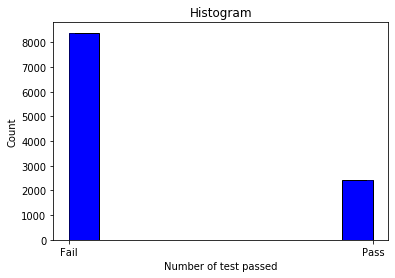

In [16]:
# matplotlib histogram

x = ["Pass","Fail"]

cnt = train_df['isPass'].value_counts()

plt.hist(train_df['isPass'], color = ['blue'], edgecolor = 'black')

# seaborn histogram
sns.distplot(train_df['isPass'], hist=True, kde=False, 
             color = ['blue'])

plt.xticks(np.arange(0, 2, 1))
positions = (0, 1)
labels = ("Fail", "Pass")
plt.xticks(positions, labels)
# Add labels
plt.title('Histogram')
plt.xlabel('Number of test passed')
plt.ylabel('Count')

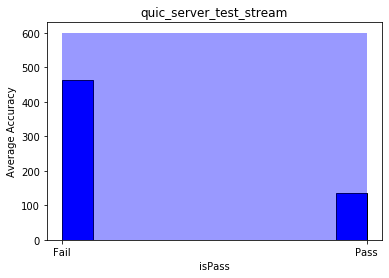

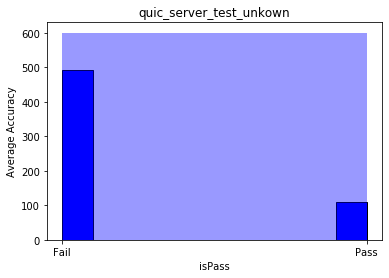

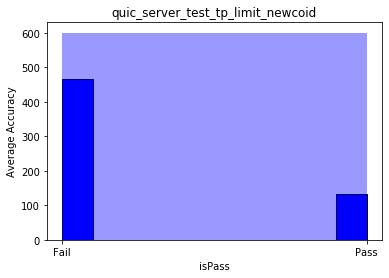

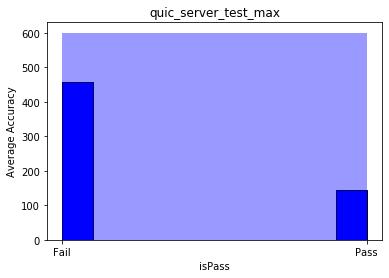

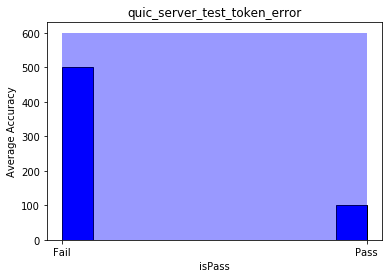

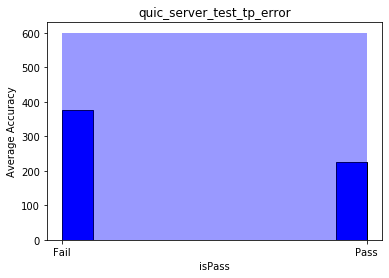

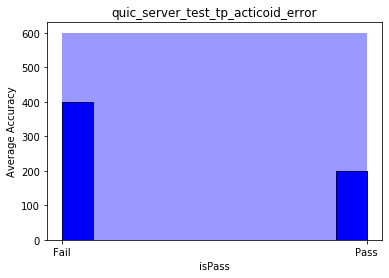

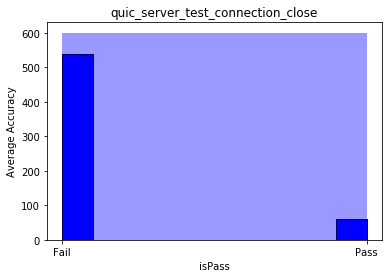

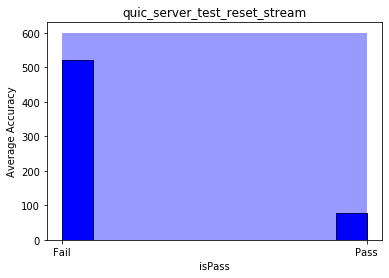

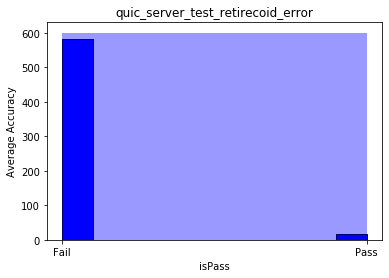

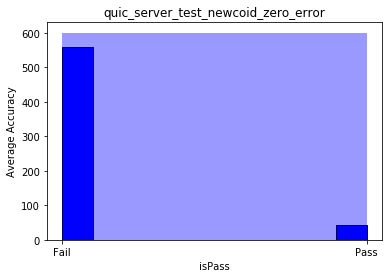

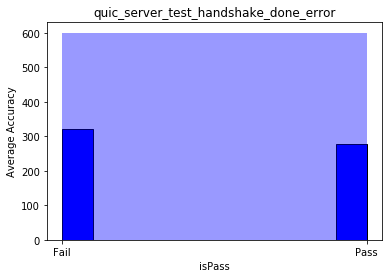

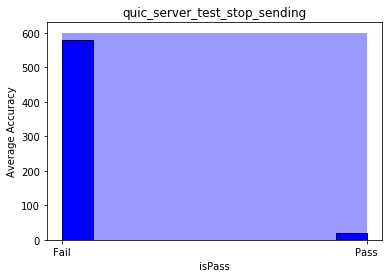

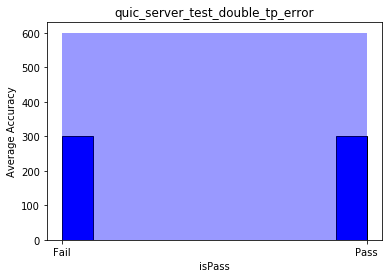

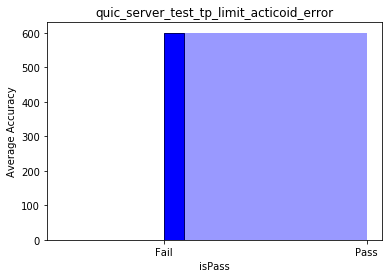

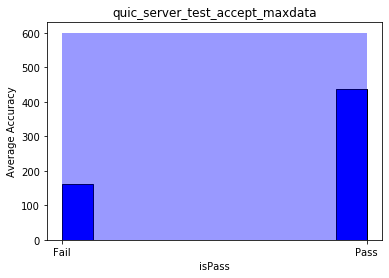

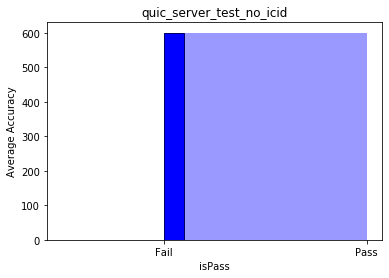

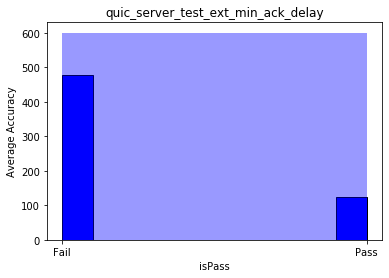

In [41]:
# Failure per test

train_df.TestName.unique()
tests = ['quic_server_test_stream', 'quic_server_test_unkown',
       'quic_server_test_tp_limit_newcoid', 'quic_server_test_max',
       'quic_server_test_token_error', 'quic_server_test_tp_error',
       'quic_server_test_tp_acticoid_error',
       'quic_server_test_connection_close',
       'quic_server_test_reset_stream',
       'quic_server_test_retirecoid_error',
       'quic_server_test_newcoid_zero_error',
       'quic_server_test_handshake_done_error',
       'quic_server_test_stop_sending',
       'quic_server_test_double_tp_error',
       'quic_server_test_tp_limit_acticoid_error',
       'quic_server_test_accept_maxdata', 'quic_server_test_no_icid',
       'quic_server_test_ext_min_ack_delay']

#plt.figure(figsize=[10,10])
#f,a = plt.subplots(2,2)
#a = a.ravel()

for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    plt.hist(subdf['isPass'], color = 'blue', edgecolor = 'black')

    # seaborn histogram
    sns.distplot(subdf['isPass'], hist=True, kde=False, 
                 color = 'blue',bins=[0, 1])
    # Add labels
    plt.title(t)
    plt.xticks(np.arange(0, 2, 1))
    positions = (0, 1)
    labels = ("Fail", "Pass")
    plt.xticks(positions, labels)
    plt.xlabel('isPass')
    plt.ylabel('Average Accuracy')
    plt.show()
    

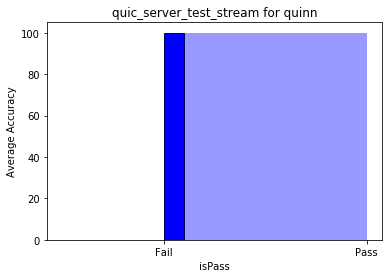

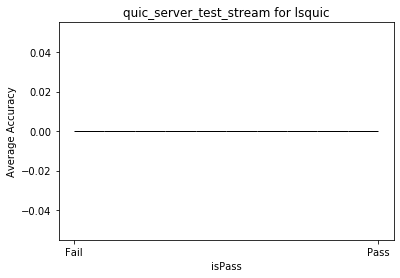

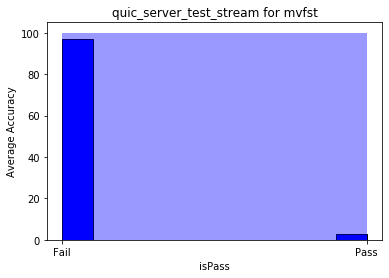

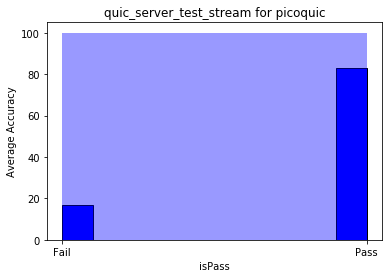

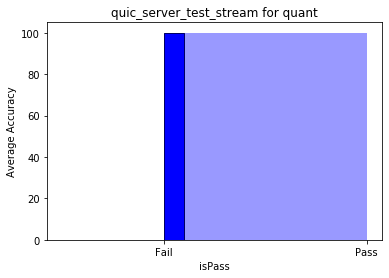

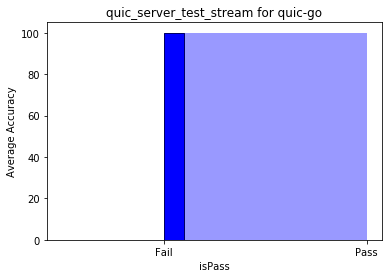

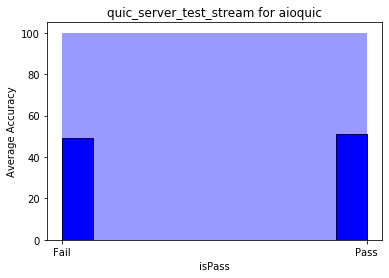

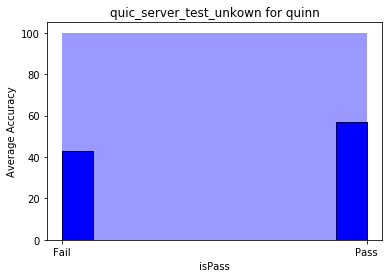

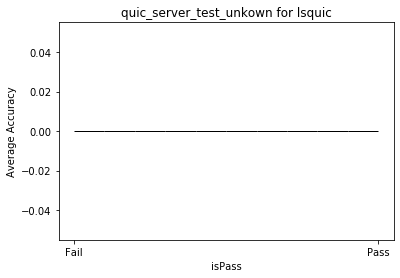

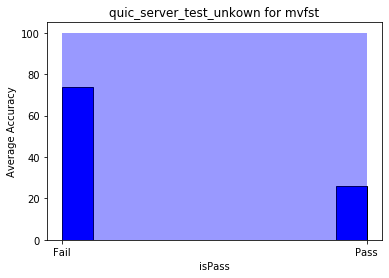

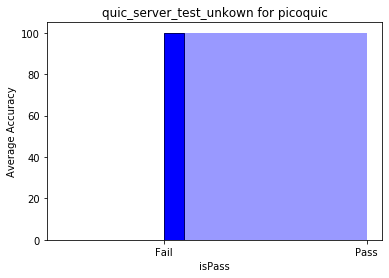

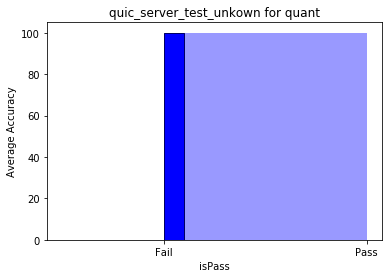

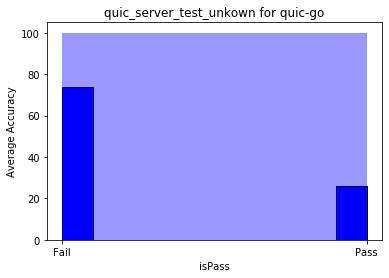

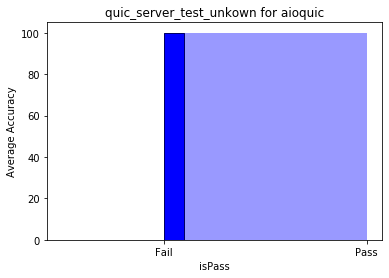

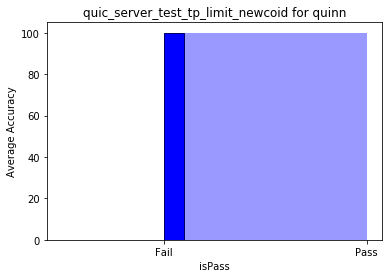

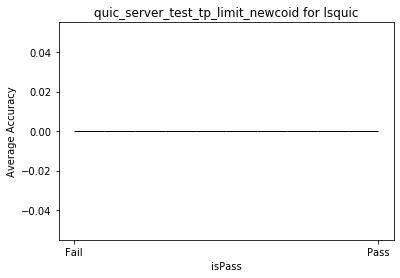

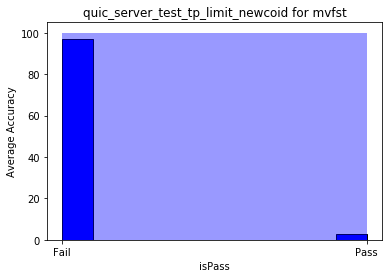

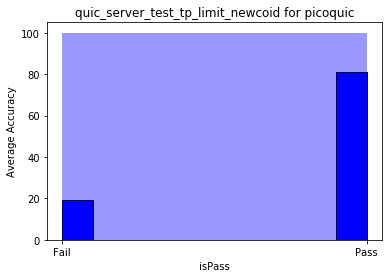

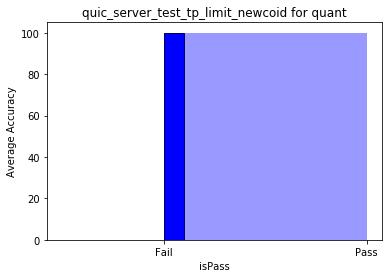

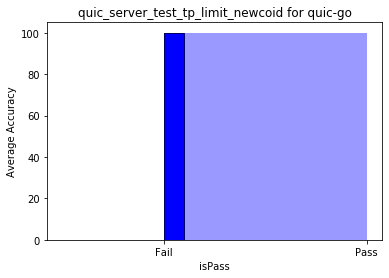

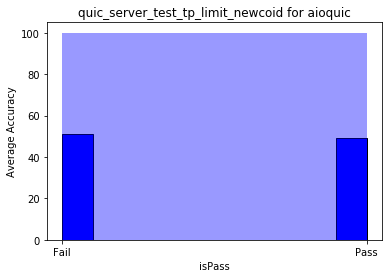

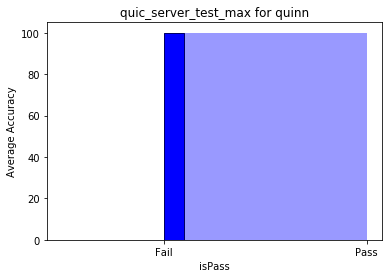

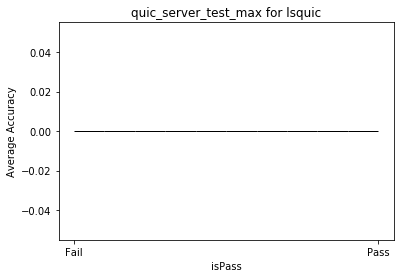

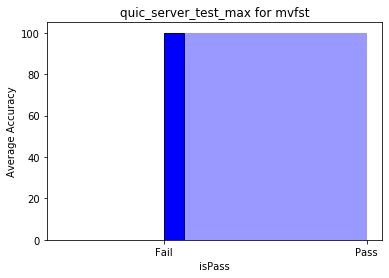

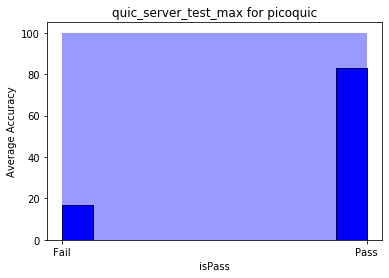

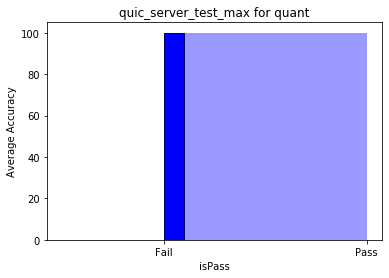

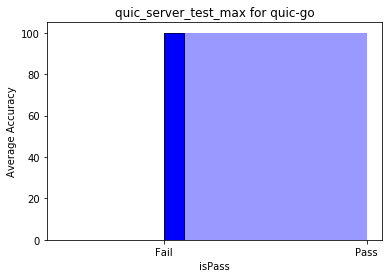

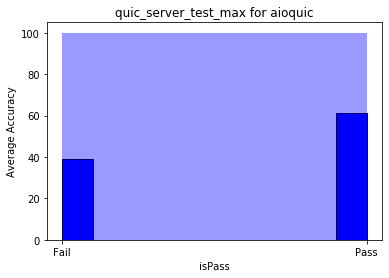

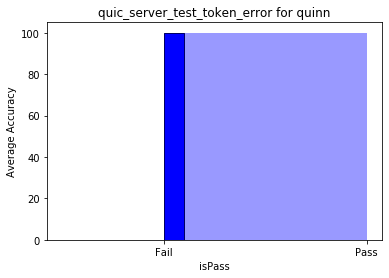

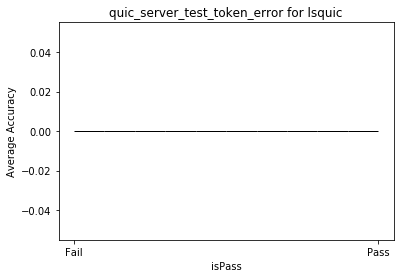

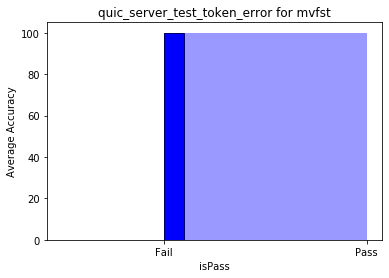

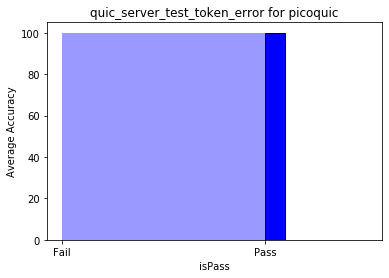

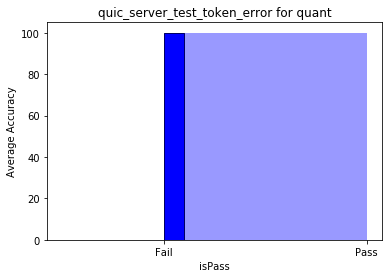

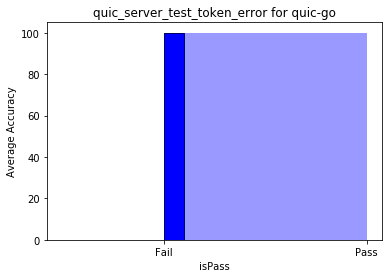

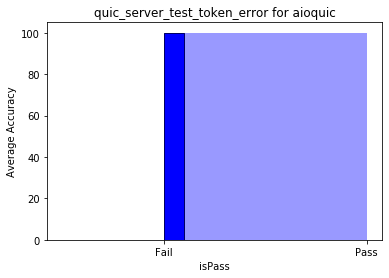

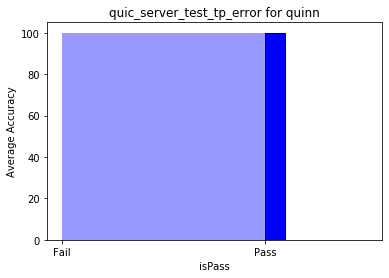

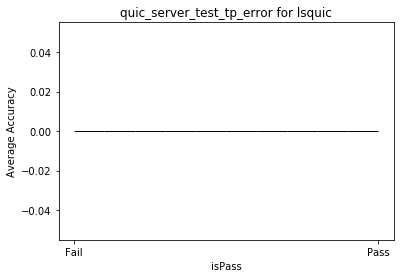

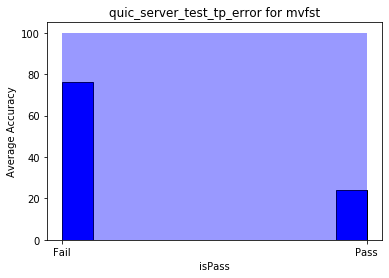

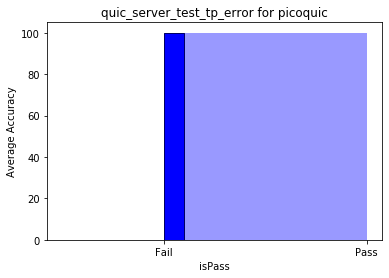

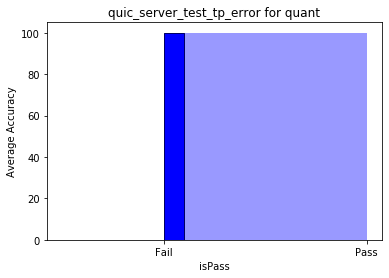

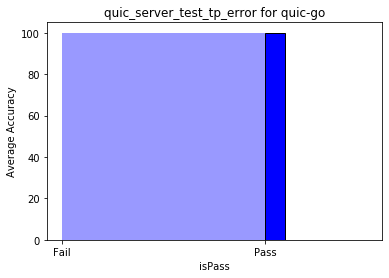

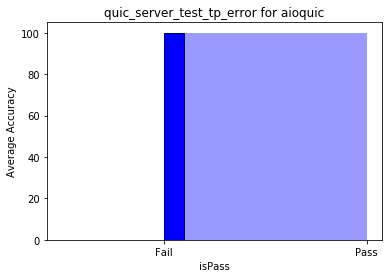

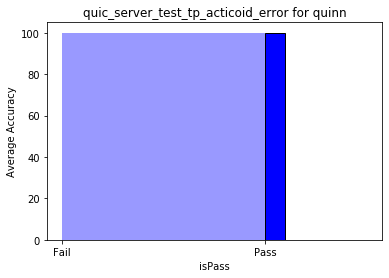

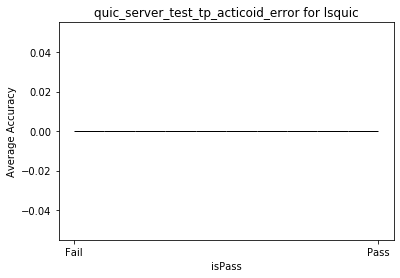

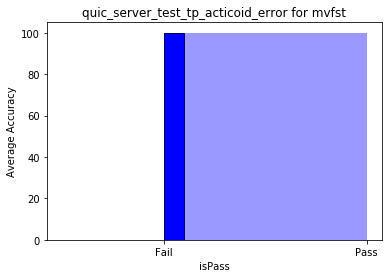

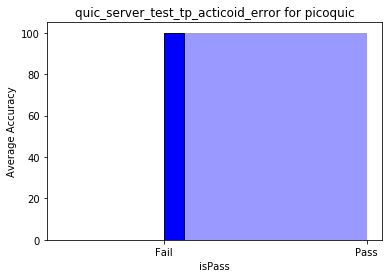

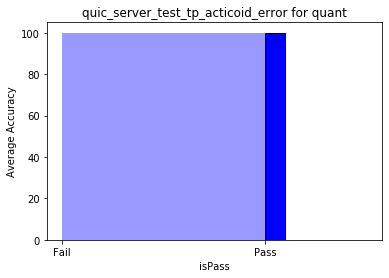

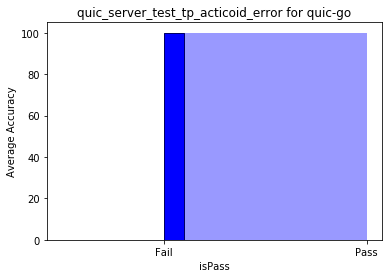

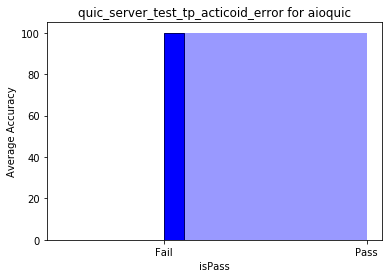

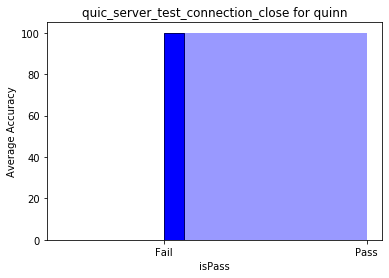

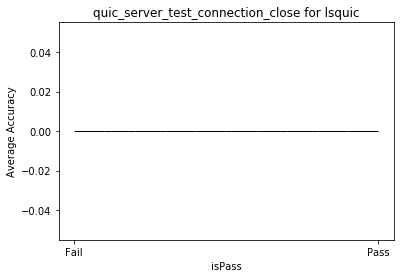

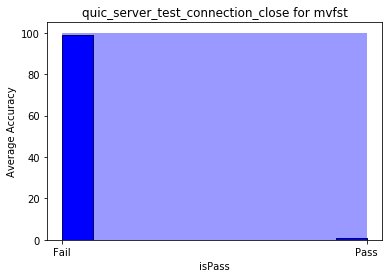

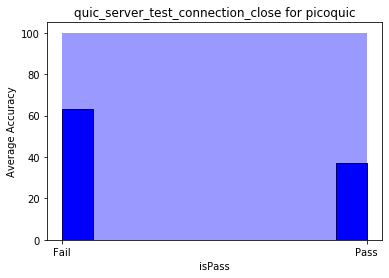

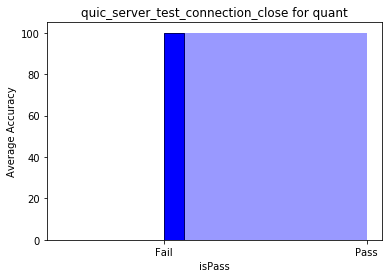

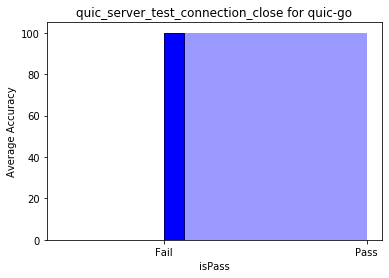

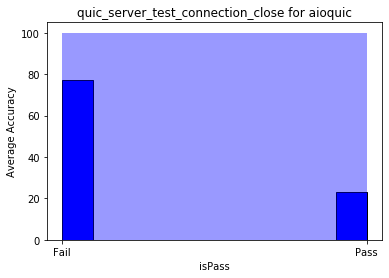

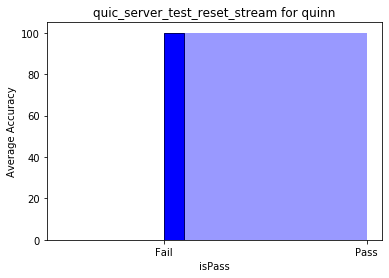

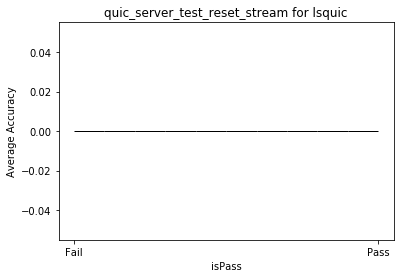

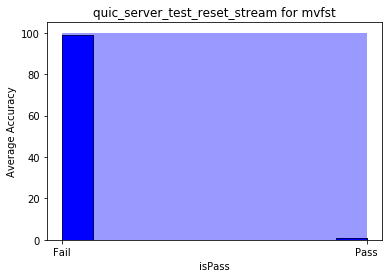

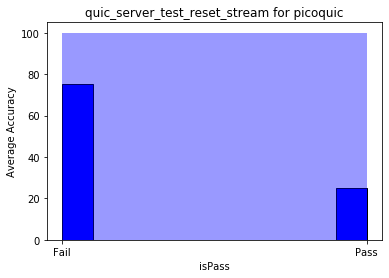

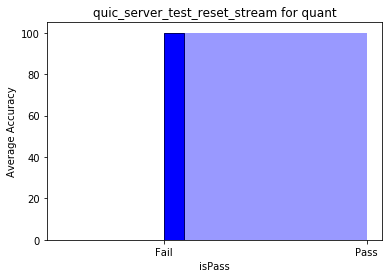

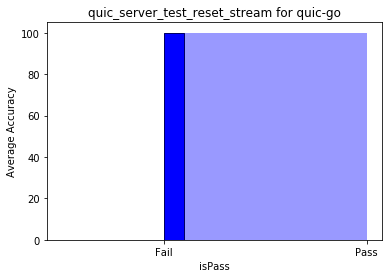

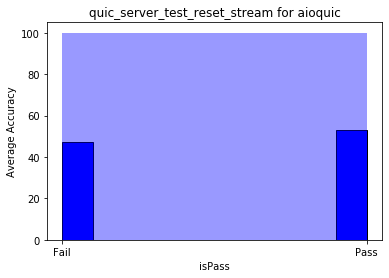

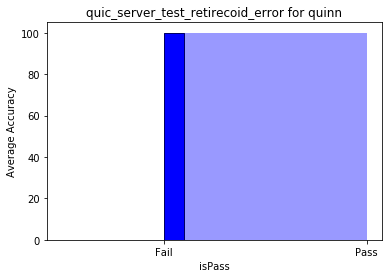

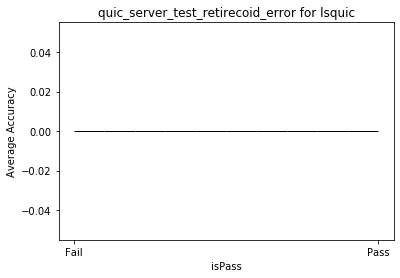

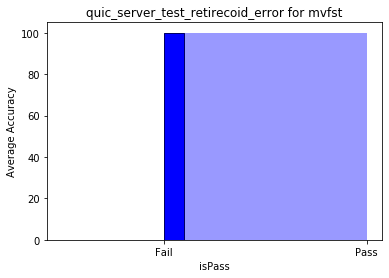

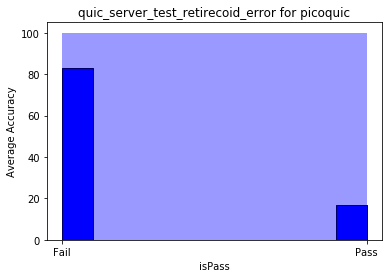

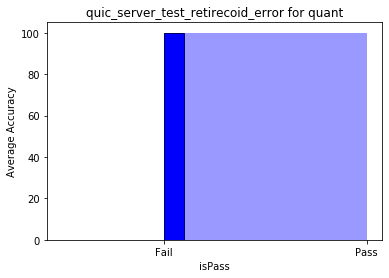

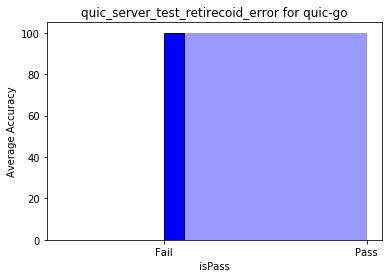

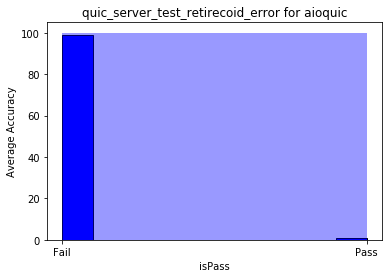

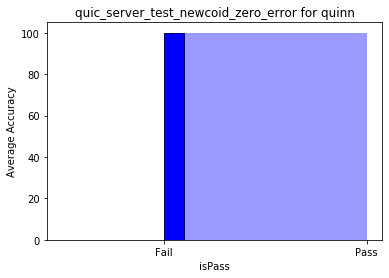

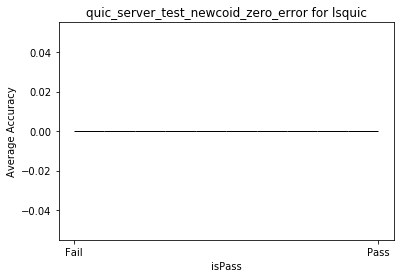

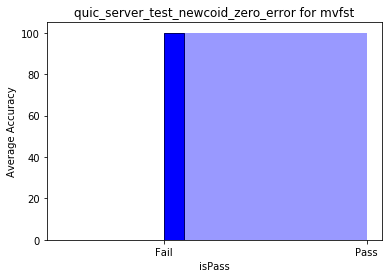

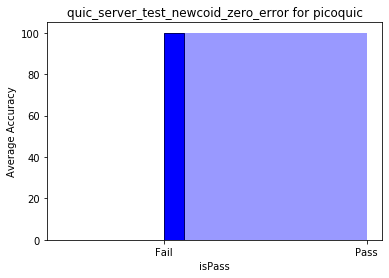

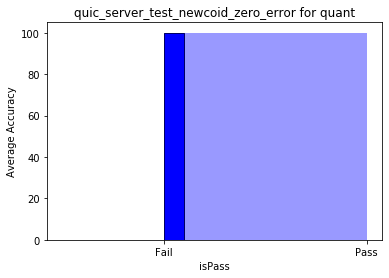

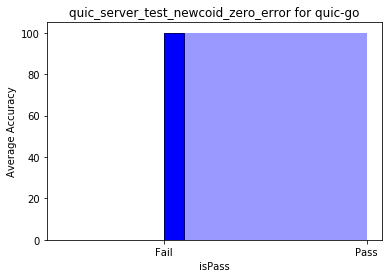

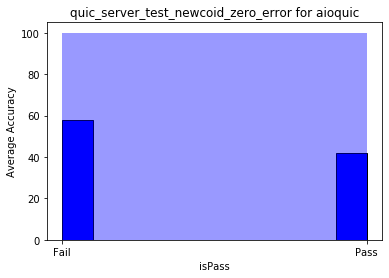

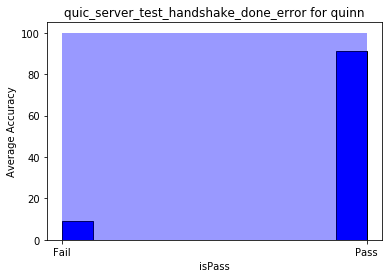

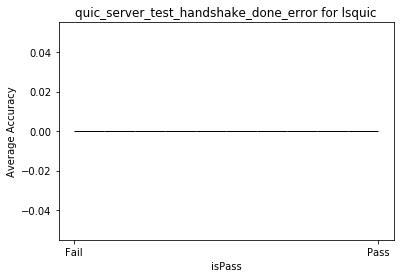

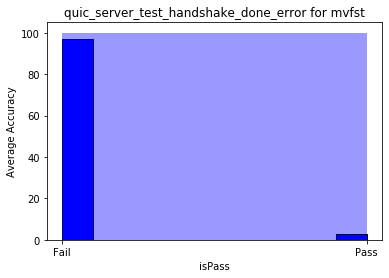

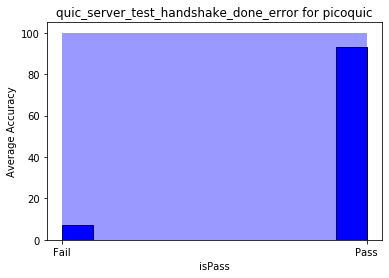

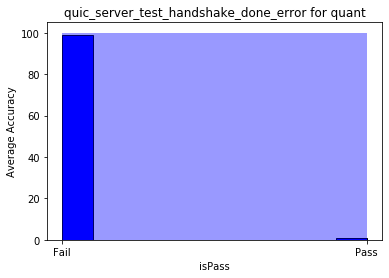

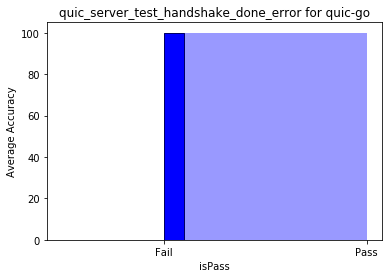

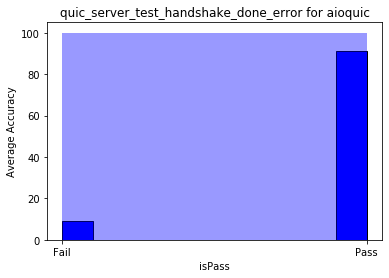

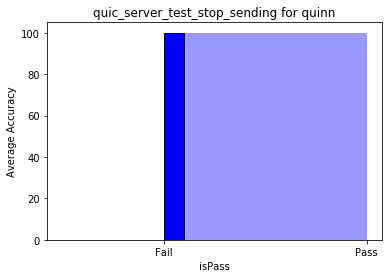

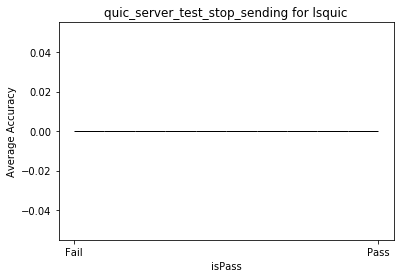

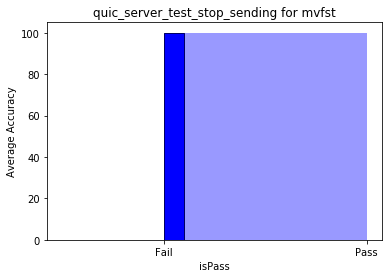

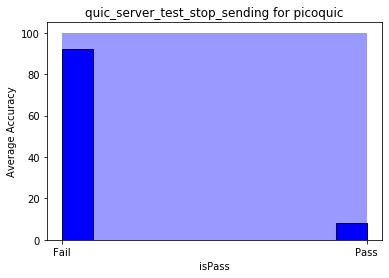

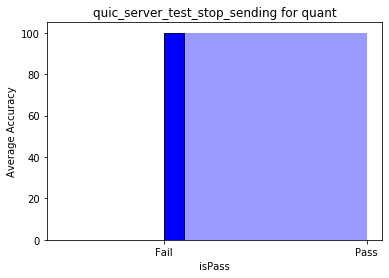

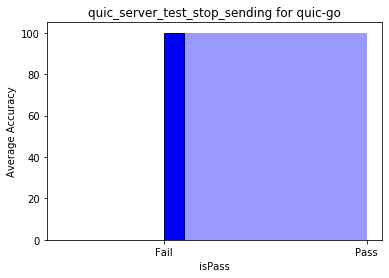

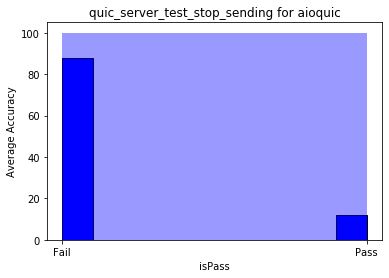

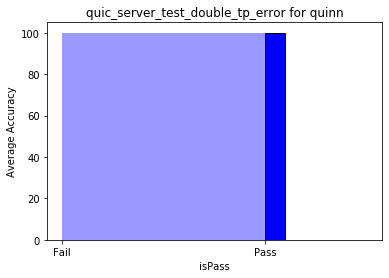

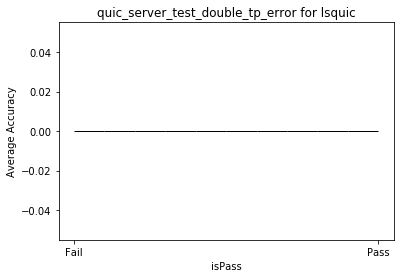

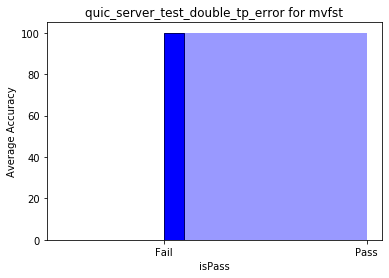

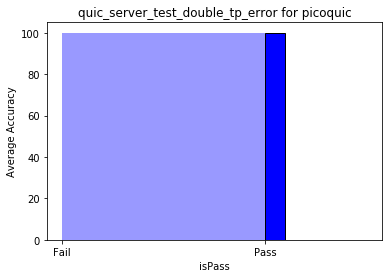

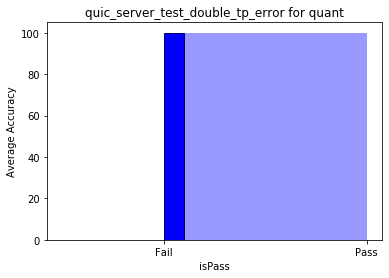

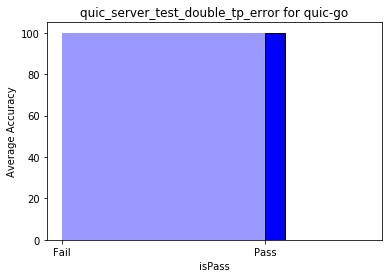

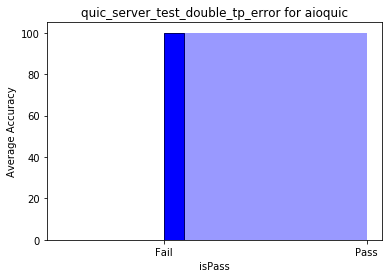

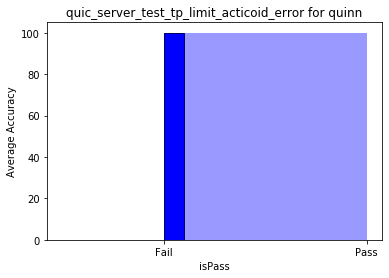

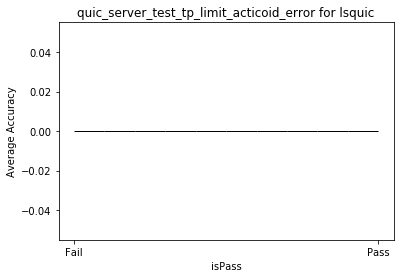

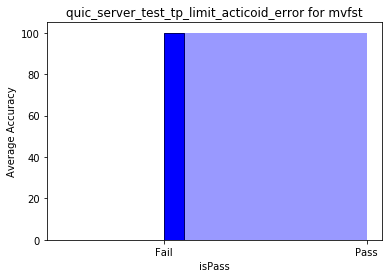

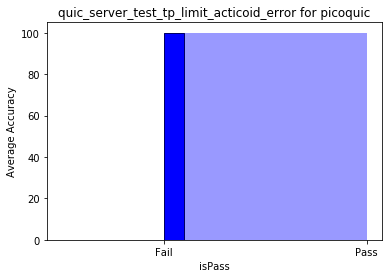

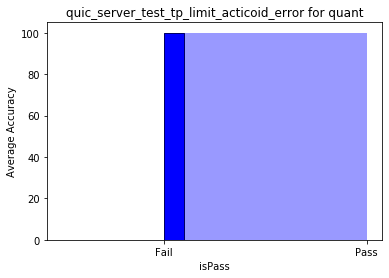

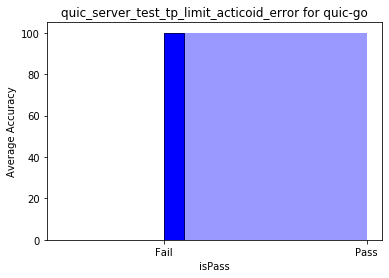

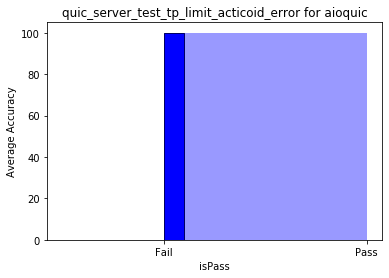

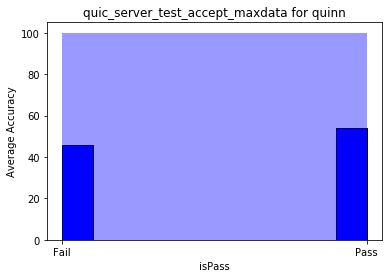

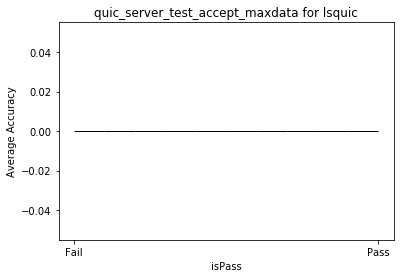

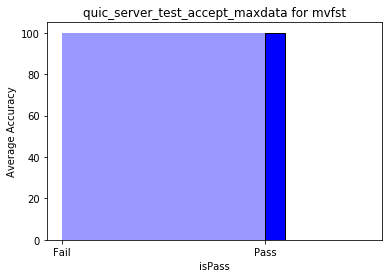

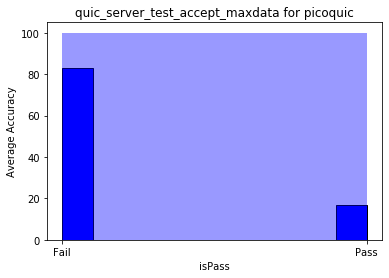

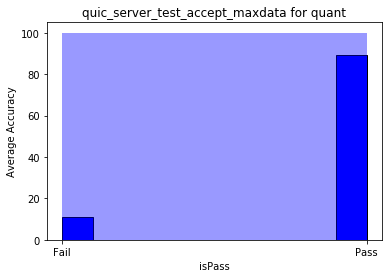

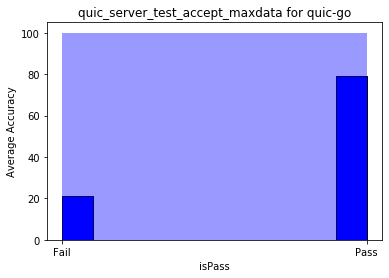

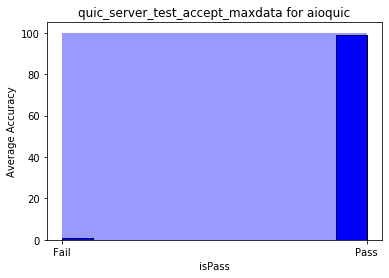

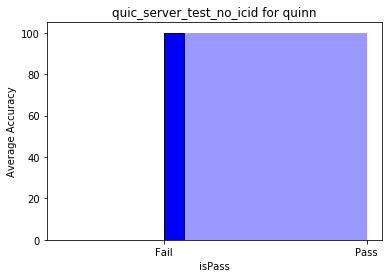

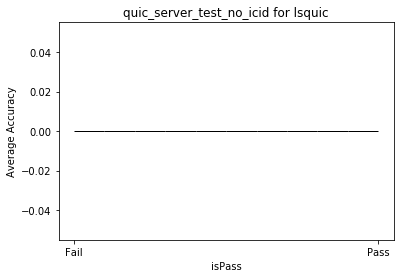

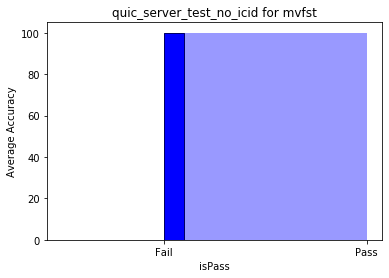

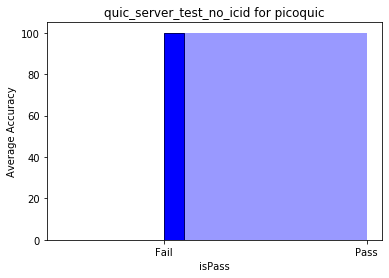

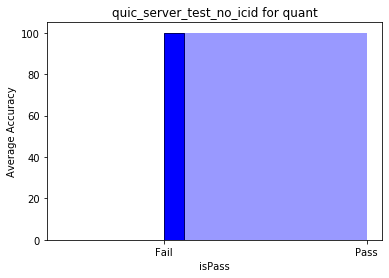

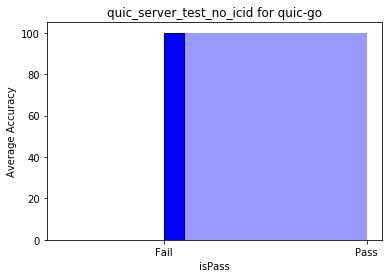

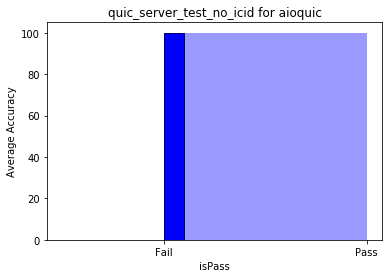

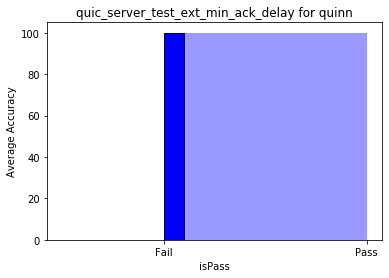

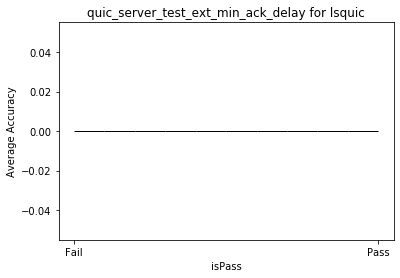

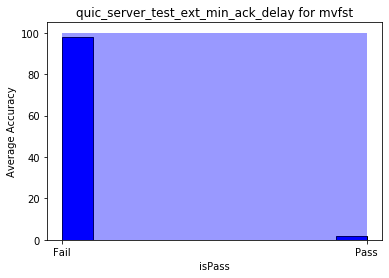

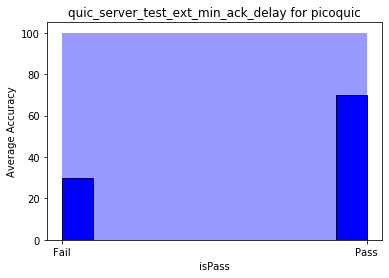

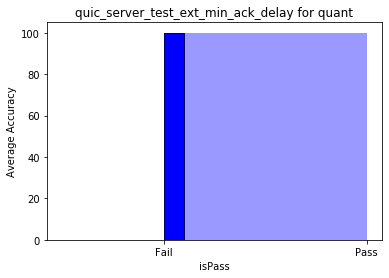

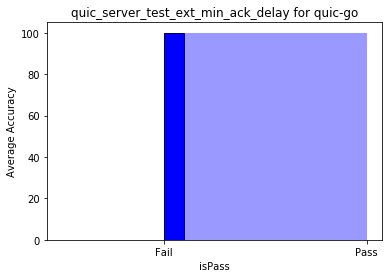

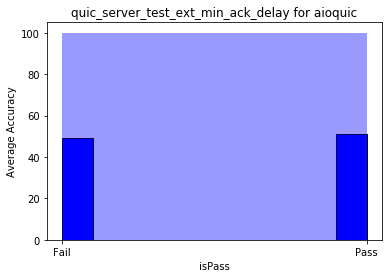

In [43]:
# Failure per test and per implementation

train_df.Implementation.unique()
tests = ['quic_server_test_stream', 'quic_server_test_unkown',
       'quic_server_test_tp_limit_newcoid', 'quic_server_test_max',
       'quic_server_test_token_error', 'quic_server_test_tp_error',
       'quic_server_test_tp_acticoid_error',
       'quic_server_test_connection_close',
       'quic_server_test_reset_stream',
       'quic_server_test_retirecoid_error',
       'quic_server_test_newcoid_zero_error',
       'quic_server_test_handshake_done_error',
       'quic_server_test_stop_sending',
       'quic_server_test_double_tp_error',
       'quic_server_test_tp_limit_acticoid_error',
       'quic_server_test_accept_maxdata', 'quic_server_test_no_icid',
       'quic_server_test_ext_min_ack_delay']

servers = ['quinn', 'lsquic', 'mvfst', 'picoquic', 'quant', 'quic-go', 'aioquic']
#plt.figure(figsize=[10,10])
#f,a = plt.subplots(2,2)
#a = a.ravel()

for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    for s in servers:
        subsubdf = subdf.loc[subdf['Implementation'] == s]
        plt.hist(subsubdf['isPass'], color = 'blue', edgecolor = 'black')

        # seaborn histogram
        sns.distplot(subsubdf['isPass'], hist=True, kde=False, 
                     color = 'blue',bins=[0, 1])
        # Add labels
        plt.xticks(np.arange(0, 1, 1))
        positions = (0, 1)
        labels = ("Fail", "Pass")
        plt.xticks(positions, labels)
        plt.title(t + " for " + s)
        plt.xlabel('isPass')
        plt.ylabel('Average Accuracy')
        plt.show()
    

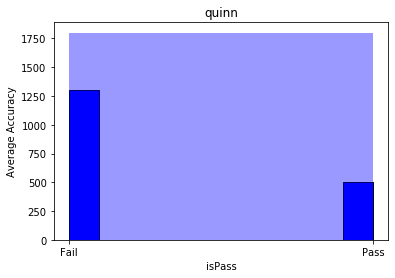

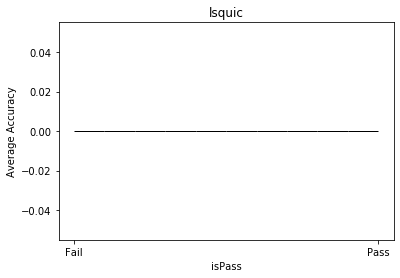

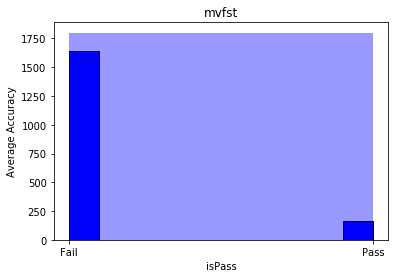

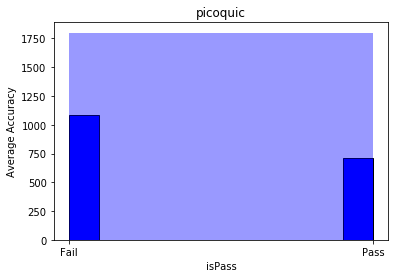

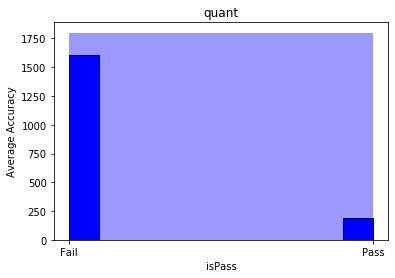

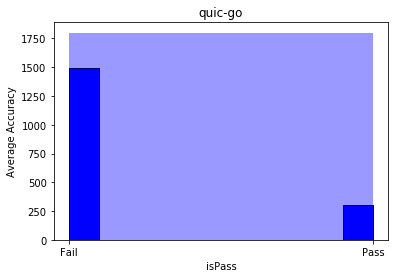

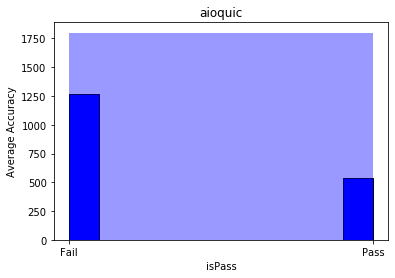

In [44]:
for t in servers:
    subdf = train_df.loc[train_df['Implementation'] == t]
    plt.hist(subdf['isPass'], color = 'blue', edgecolor = 'black')

    # seaborn histogram
    sns.distplot(subdf['isPass'], hist=True, kde=False, 
                 color = 'blue',bins=[0, 1])
    # Add labels
    plt.title(t)
    plt.xticks(np.arange(0, 2, 1))
    positions = (0, 1)
    labels = ("Fail", "Pass")
    plt.xticks(positions, labels)
    plt.xlabel('isPass')
    plt.ylabel('Average Accuracy')
    plt.show()
    

    Implementation    Mode                           TestName  Status  \
Run                                                                     
0            quant  server            quic_server_test_stream     NaN   
1          quic-go  server            quic_server_test_stream     NaN   
2          quic-go  server            quic_server_test_stream     NaN   
3          quic-go  server            quic_server_test_stream     NaN   
4          quic-go  server            quic_server_test_stream     NaN   
5          aioquic  server            quic_server_test_stream     NaN   
6          aioquic  server            quic_server_test_stream     NaN   
7          aioquic  server            quic_server_test_stream     NaN   
8          aioquic  server            quic_server_test_stream     NaN   
9            quinn  server            quic_server_test_unkown     NaN   
10           quinn  server            quic_server_test_unkown     NaN   
11           quinn  server            quic_server_t

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


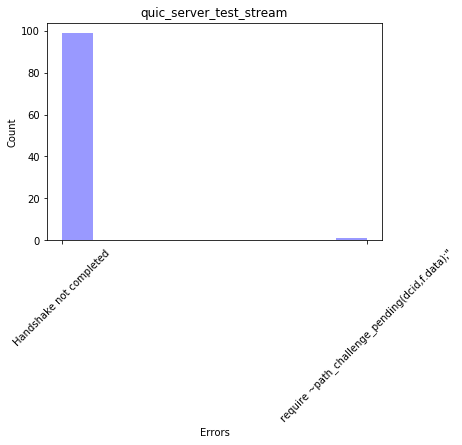

Errors for mvfst in test quic_server_test_stream
['Handshake not completed' 'No Error'
 'frame.connection_close:{err_code:0xc}' 'Segmentation Fault 134']
Run
411    0
412    0
413    0
629    0
630    0
Name: ErrorsCode, dtype: int64
[0 1 2 3]
('Handshake not completed', 'No Error', 'frame.connection_close:{err_code:0xc}', 'Segmentation Fault 134')


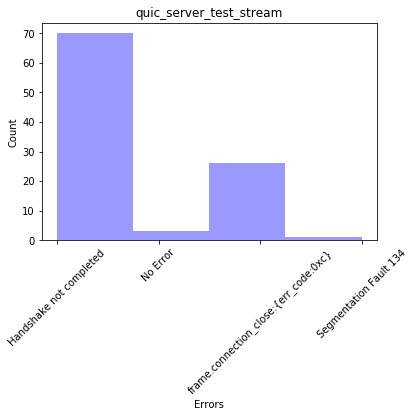

Errors for picoquic in test quic_server_test_stream
['No Error'
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"'
 'Handshake not completed']
Run
414    2
415    8
416    2
417    2
421    2
Name: ErrorsCode, dtype: int64
[0 1 2]
('No Error', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'Handshake not completed')


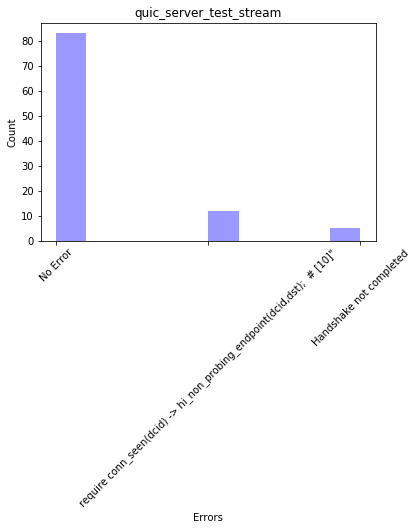

Errors for quic-go in test quic_server_test_stream
['Handshake not completed']
Run
1      0
2      0
3      0
4      0
424    0
Name: ErrorsCode, dtype: int64
[0]
('Handshake not completed',)


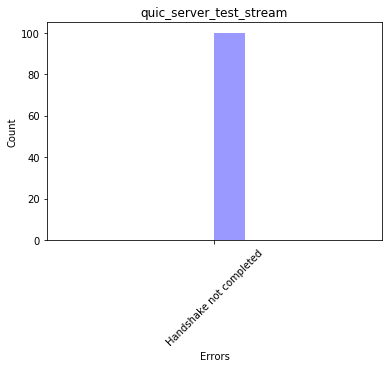

Errors for aioquic in test quic_server_test_stream
['frame.connection_close:{err_code:0xa}' 'No Error'
 'Handshake not completed'
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']
Run
5      1
6      2
7      2
8      1
426    1
Name: ErrorsCode, dtype: int64
[0 1 2 3]
('frame.connection_close:{err_code:0xa}', 'No Error', 'Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"')


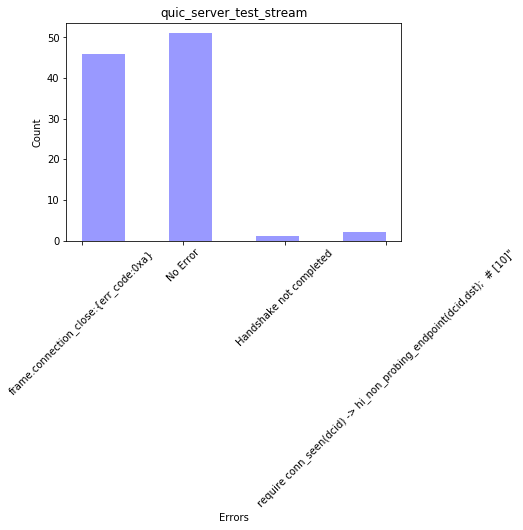

Errors for quinn in test quic_server_test_unkown
['No Error' 'Handshake not completed' 'require is_frame_encoding_error;"']
Run
9      2
10     0
11     3
12     2
428    0
Name: ErrorsCode, dtype: int64
[0 1 2]
('No Error', 'Handshake not completed', 'require is_frame_encoding_error;"')


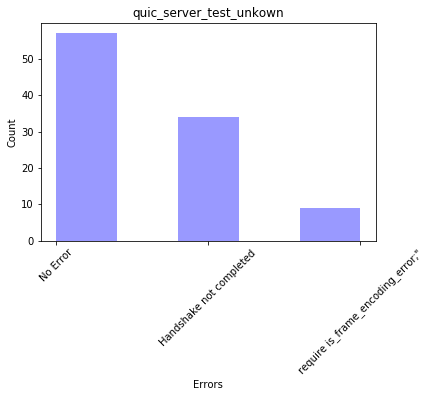

Errors for mvfst in test quic_server_test_unkown
['Segmentation Fault 139' 'No Error' 'Handshake not completed'
 'require is_frame_encoding_error;"'
 'frame.connection_close:{err_code:0x7}']
Run
13     4
14     2
15     0
430    2
641    2
Name: ErrorsCode, dtype: int64
[0 1 2 3 4]
('Segmentation Fault 139', 'No Error', 'Handshake not completed', 'require is_frame_encoding_error;"', 'frame.connection_close:{err_code:0x7}')


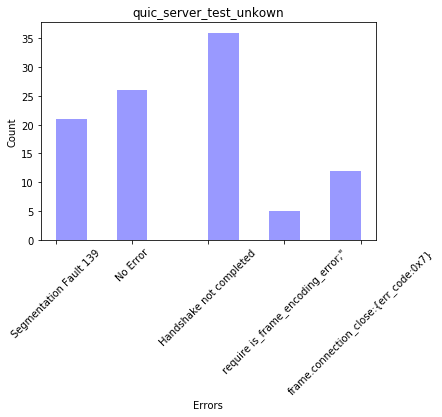

Errors for picoquic in test quic_server_test_unkown
['frame.connection_close:{err_code:0xa}' 'Handshake not completed'
 'require is_frame_encoding_error;"']
Run
16     1
17     0
407    1
431    3
432    1
Name: ErrorsCode, dtype: int64
[0 1 2]
('frame.connection_close:{err_code:0xa}', 'Handshake not completed', 'require is_frame_encoding_error;"')


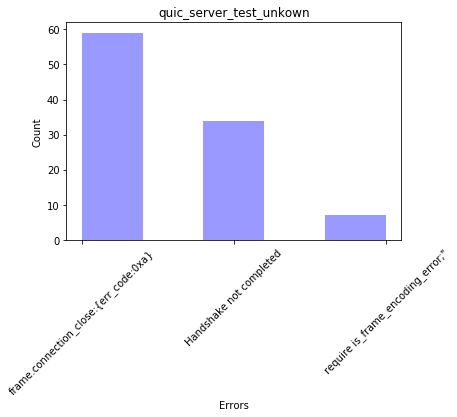

Errors for quic-go in test quic_server_test_unkown
['frame.connection_close:{err_code:0x7}' 'Handshake not completed'
 'No Error' 'require is_frame_encoding_error;"']
Run
21     5
22     0
23     5
24     5
435    0
Name: ErrorsCode, dtype: int64
[0 1 2 3]
('frame.connection_close:{err_code:0x7}', 'Handshake not completed', 'No Error', 'require is_frame_encoding_error;"')


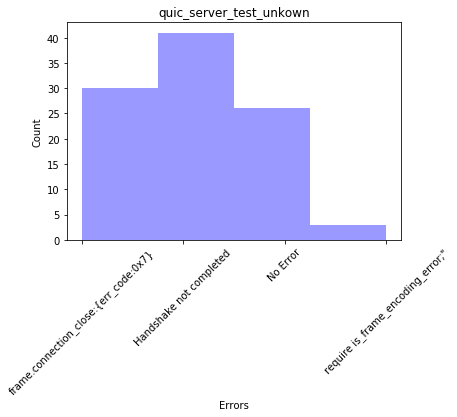

Errors for aioquic in test quic_server_test_unkown
['frame.connection_close:{err_code:0xa}' 'Handshake not completed'
 'require is_frame_encoding_error;"']
Run
25     1
26     0
27     0
28     1
437    1
Name: ErrorsCode, dtype: int64
[0 1 2]
('frame.connection_close:{err_code:0xa}', 'Handshake not completed', 'require is_frame_encoding_error;"')


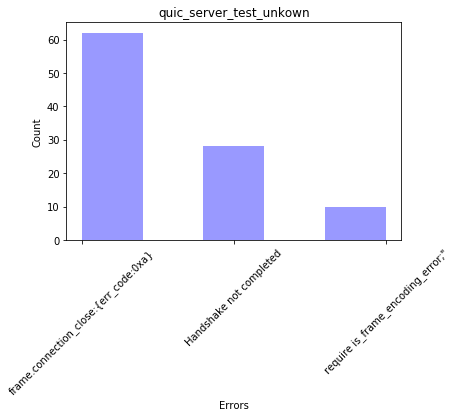

Errors for quinn in test quic_server_test_tp_limit_newcoid
['Handshake not completed'
 'require ~path_challenge_pending(dcid,f.data);"']
Run
29     0
30     0
31     0
32     0
439    0
Name: ErrorsCode, dtype: int64
[0 1]
('Handshake not completed', 'require ~path_challenge_pending(dcid,f.data);"')


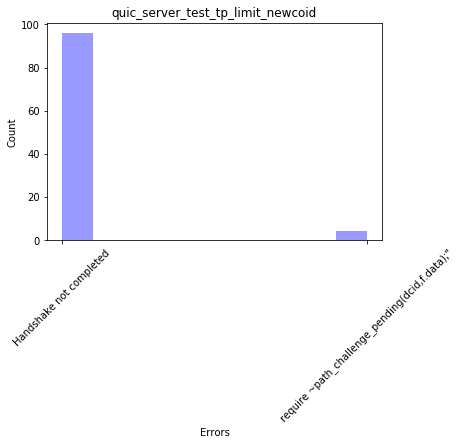

Errors for mvfst in test quic_server_test_tp_limit_newcoid
['Handshake not completed' 'frame.connection_close:{err_code:0xc}'
 'No Error']
Run
33      0
34      0
35      0
36      0
441    34
Name: ErrorsCode, dtype: int64
[0 1 2]
('Handshake not completed', 'frame.connection_close:{err_code:0xc}', 'No Error')


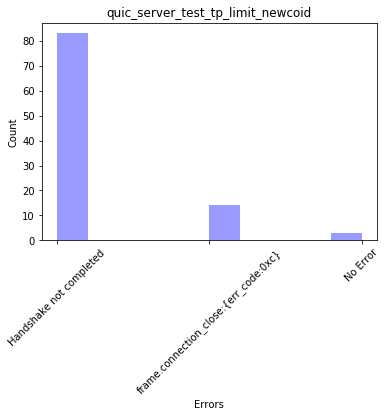

Errors for picoquic in test quic_server_test_tp_limit_newcoid
['No Error' 'Handshake not completed'
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']
Run
37     2
38     2
39     2
40     2
443    0
Name: ErrorsCode, dtype: int64
[0 1 2]
('No Error', 'Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"')


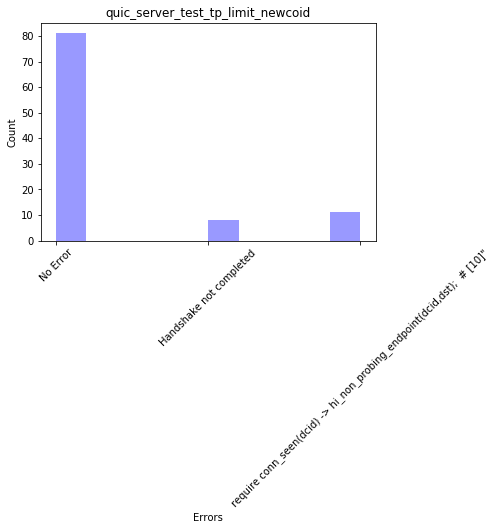

Errors for quic-go in test quic_server_test_tp_limit_newcoid
['Handshake not completed']
Run
45     0
46     0
47     0
48     0
447    0
Name: ErrorsCode, dtype: int64
[0]
('Handshake not completed',)


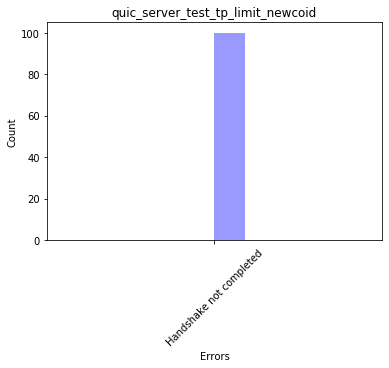

Errors for aioquic in test quic_server_test_tp_limit_newcoid
['frame.connection_close:{err_code:0xa}' 'No Error'
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']
Run
49     1
50     1
51     2
52     2
614    1
Name: ErrorsCode, dtype: int64
[0 1 2]
('frame.connection_close:{err_code:0xa}', 'No Error', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"')


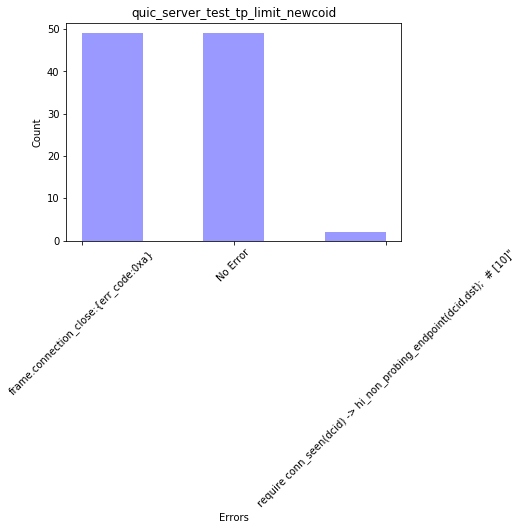

Errors for quinn in test quic_server_test_max
['Handshake not completed'
 'require ~path_challenge_pending(dcid,f.data);"'
 'require stream_id_allowed(dcid,f.id);  # [6]"']
Run
53     0
54     0
55     0
56     0
616    0
Name: ErrorsCode, dtype: int64
[0 1 2]
('Handshake not completed', 'require ~path_challenge_pending(dcid,f.data);"', 'require stream_id_allowed(dcid,f.id);  # [6]"')


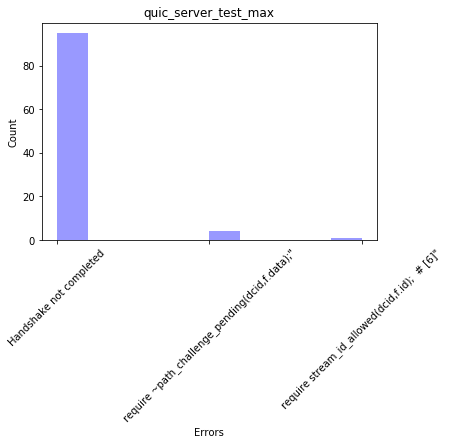

Errors for mvfst in test quic_server_test_max
['Handshake not completed' 'frame.connection_close:{err_code:0xc}'
 'Segmentation Fault 134']
Run
57     0
58     0
59     0
60     0
618    0
Name: ErrorsCode, dtype: int64
[0 1 2]
('Handshake not completed', 'frame.connection_close:{err_code:0xc}', 'Segmentation Fault 134')


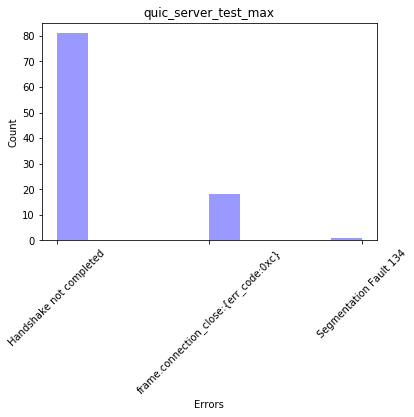

Errors for picoquic in test quic_server_test_max
['No Error'
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"'
 'Handshake not completed']
Run
61     2
62     2
63     2
64     2
620    2
Name: ErrorsCode, dtype: int64
[0 1 2]
('No Error', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'Handshake not completed')


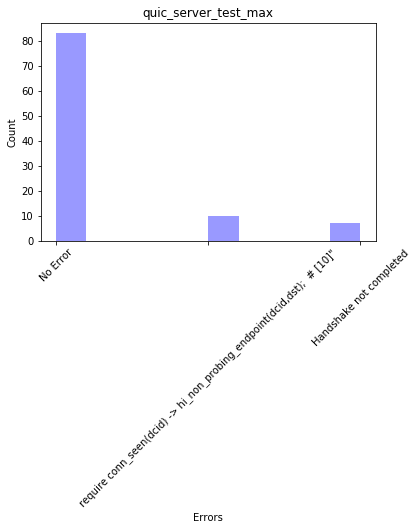

Errors for quic-go in test quic_server_test_max
['Handshake not completed']
Run
69     0
70     0
71     0
72     0
624    0
Name: ErrorsCode, dtype: int64
[0]
('Handshake not completed',)


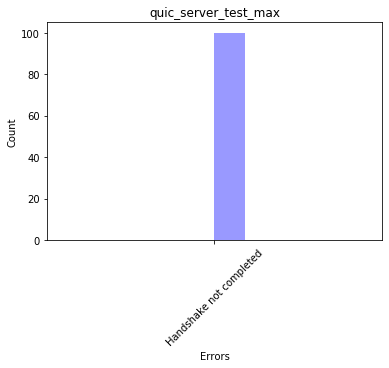

Errors for aioquic in test quic_server_test_max
['No Error' 'frame.connection_close:{err_code:0xa}'
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']
Run
73     2
74     1
75     2
76     2
626    2
Name: ErrorsCode, dtype: int64
[0 1 2]
('No Error', 'frame.connection_close:{err_code:0xa}', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"')


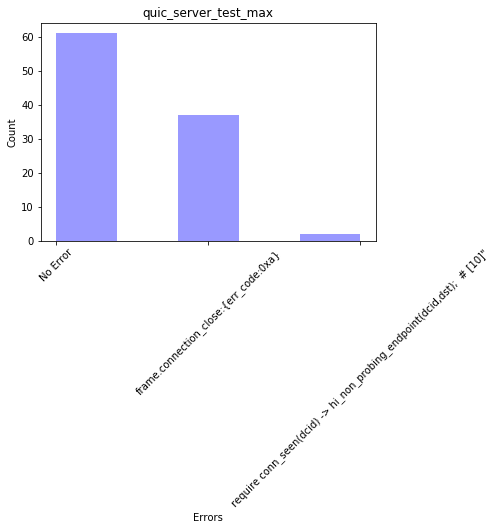

Errors for quinn in test quic_server_test_token_error
['Handshake not completed']
Run
77     0
78     0
79     0
80     0
448    0
Name: ErrorsCode, dtype: int64
[0]
('Handshake not completed',)


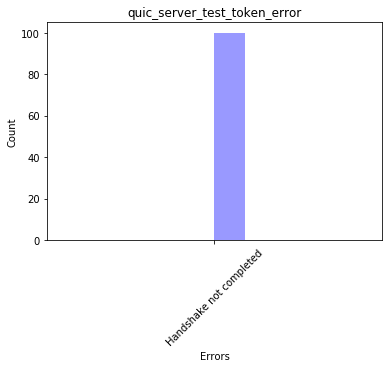

Errors for mvfst in test quic_server_test_token_error
['Handshake not completed']
Run
81     0
82     0
83     0
84     0
450    0
Name: ErrorsCode, dtype: int64
[0]
('Handshake not completed',)


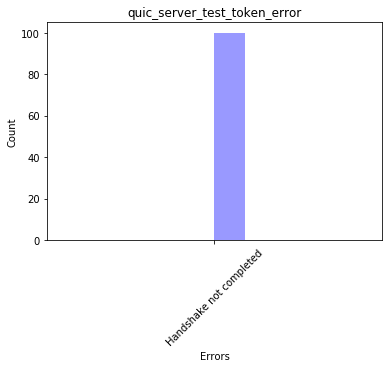

Errors for picoquic in test quic_server_test_token_error
['No Error']
Run
85     2
86     2
87     2
88     2
452    2
Name: ErrorsCode, dtype: int64
[0]
('No Error',)


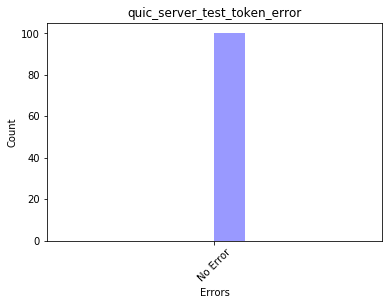

Errors for quic-go in test quic_server_test_token_error
['Handshake not completed']
Run
93     0
94     0
95     0
96     0
456    0
Name: ErrorsCode, dtype: int64
[0]
('Handshake not completed',)


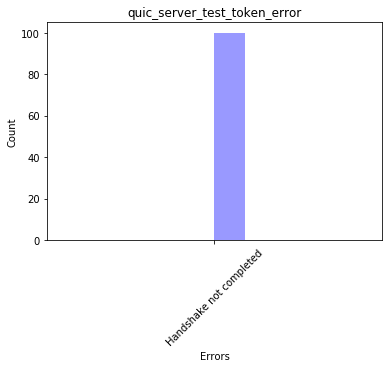

Errors for aioquic in test quic_server_test_token_error
['Handshake not completed']
Run
97     0
98     0
99     0
100    0
458    0
Name: ErrorsCode, dtype: int64
[0]
('Handshake not completed',)


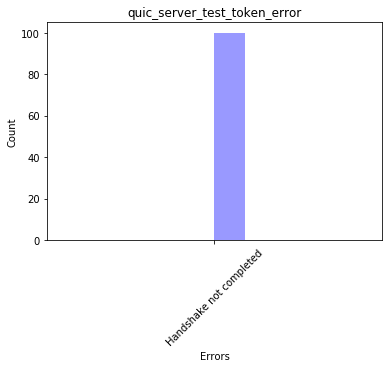

Errors for quinn in test quic_server_test_tp_error
['No Error']
Run
101    2
102    2
103    2
104    2
460    2
Name: ErrorsCode, dtype: int64
[0]
('No Error',)


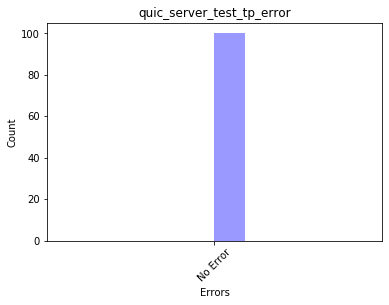

Errors for mvfst in test quic_server_test_tp_error
['Handshake not completed' 'No Error'
 'frame.connection_close:{err_code:0x8}']
Run
105    0
106    0
107    0
108    0
462    2
Name: ErrorsCode, dtype: int64
[0 1 2]
('Handshake not completed', 'No Error', 'frame.connection_close:{err_code:0x8}')


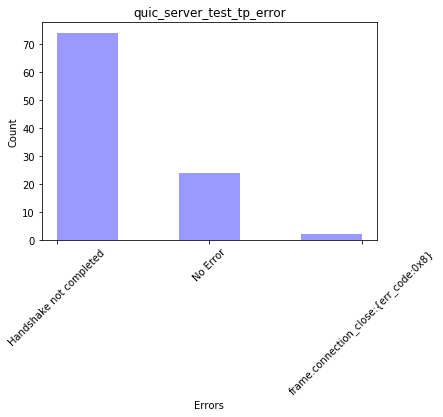

Errors for picoquic in test quic_server_test_tp_error
['Handshake not completed'
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"'
 'require is_transport_parameter_error;"']
Run
109    0
110    0
111    0
112    0
464    0
Name: ErrorsCode, dtype: int64
[0 1 2]
('Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'require is_transport_parameter_error;"')


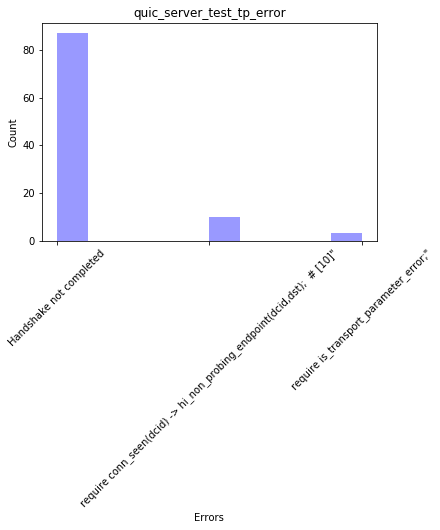

Errors for quic-go in test quic_server_test_tp_error
['No Error']
Run
115    2
116    2
117    2
118    2
467    2
Name: ErrorsCode, dtype: int64
[0]
('No Error',)


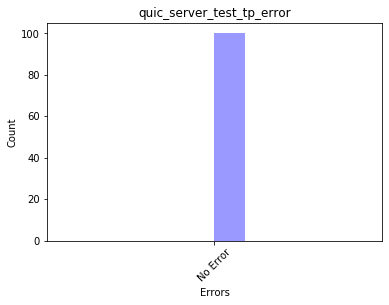

Errors for aioquic in test quic_server_test_tp_error
['Handshake not completed' 'frame.connection_close:{err_code:0xa}'
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']
Run
119    0
120    0
121    1
122    0
469    0
Name: ErrorsCode, dtype: int64
[0 1 2]
('Handshake not completed', 'frame.connection_close:{err_code:0xa}', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"')


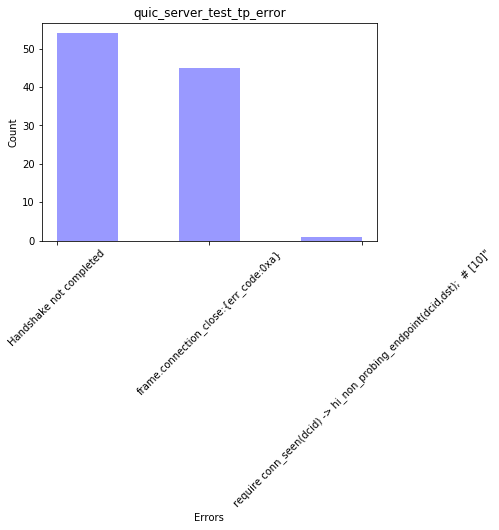

Errors for quinn in test quic_server_test_tp_acticoid_error
['No Error']
Run
123    2
124    2
125    2
126    2
471    2
Name: ErrorsCode, dtype: int64
[0]
('No Error',)


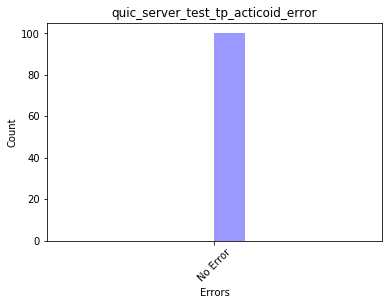

Errors for mvfst in test quic_server_test_tp_acticoid_error
['Handshake not completed' 'frame.connection_close:{err_code:0xc}'
 'Segmentation Fault 134']
Run
127    0
128    0
129    0
130    0
473    0
Name: ErrorsCode, dtype: int64
[0 1 2]
('Handshake not completed', 'frame.connection_close:{err_code:0xc}', 'Segmentation Fault 134')


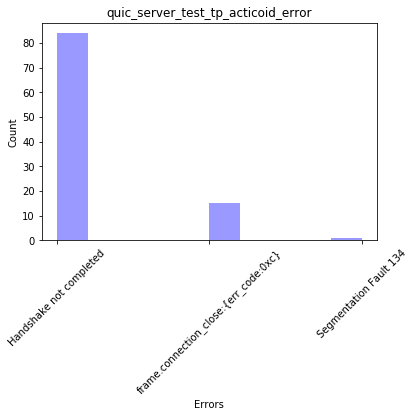

Errors for picoquic in test quic_server_test_tp_acticoid_error
['Handshake not completed'
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"'
 'require is_transport_parameter_error;"']
Run
131    0
132    8
133    0
134    0
475    0
Name: ErrorsCode, dtype: int64
[0 1 2]
('Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'require is_transport_parameter_error;"')


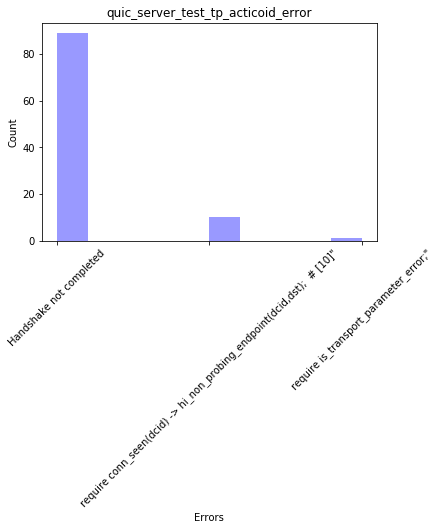

Errors for quic-go in test quic_server_test_tp_acticoid_error
['Handshake not completed']
Run
139    0
140    0
141    0
142    0
479    0
Name: ErrorsCode, dtype: int64
[0]
('Handshake not completed',)


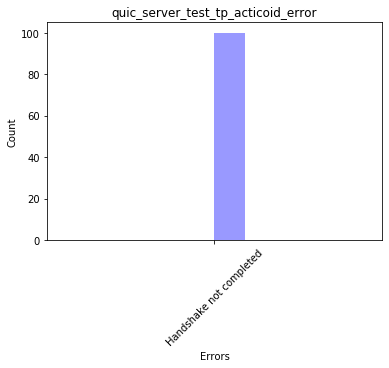

Errors for aioquic in test quic_server_test_tp_acticoid_error
['Handshake not completed']
Run
143    0
144    0
145    0
146    0
481    0
Name: ErrorsCode, dtype: int64
[0]
('Handshake not completed',)


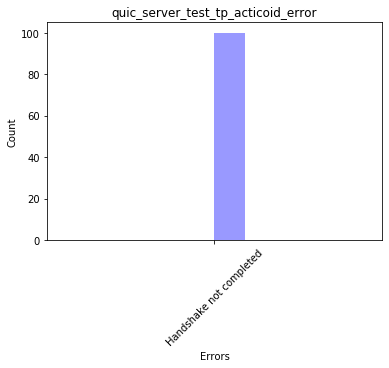

Errors for quinn in test quic_server_test_connection_close
['frame.connection_close:{err_code:0xa2d8}'
 'frame.connection_close:{err_code:0xfe9b}'
 'frame.connection_close:{err_code:0xa0ff}'
 'frame.connection_close:{err_code:0x3cd5}'
 'frame.connection_close:{err_code:0x2cc7}'
 'frame.connection_close:{err_code:0xc9ef}'
 'frame.connection_close:{err_code:0x68e4}'
 'frame.connection_close:{err_code:0xad46}'
 'frame.connection_close:{err_code:0xf6b}'
 'frame.connection_close:{err_code:0xf27b}'
 'frame.connection_close:{err_code:0x46ef}'
 'frame.connection_close:{err_code:0xa745}'
 'frame.connection_close:{err_code:0xf6fa}'
 'frame.connection_close:{err_code:0xe9d1}'
 'frame.connection_close:{err_code:0x45e3}'
 'frame.connection_close:{err_code:0xf965}'
 'frame.connection_close:{err_code:0x2ed0}'
 'frame.connection_close:{err_code:0xfe51}'
 'frame.connection_close:{err_code:0x8a75}'
 'frame.connection_close:{err_code:0x4a2e}'
 'frame.connection_close:{err_code:0x35e6}'
 'frame.connection

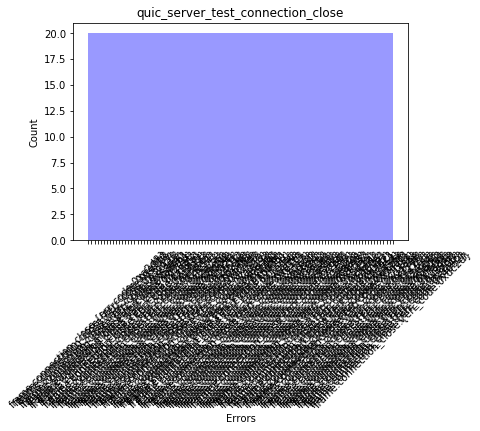

Errors for mvfst in test quic_server_test_connection_close
['frame.connection_close:{err_code:0xde5c}'
 'frame.connection_close:{err_code:0x545d}'
 'frame.connection_close:{err_code:0xfca6}'
 'frame.connection_close:{err_code:0xf664}'
 'frame.connection_close:{err_code:0x5b22}'
 'frame.connection_close:{err_code:0xe9b5}'
 'frame.connection_close:{err_code:0x4363}'
 'frame.connection_close:{err_code:0xc}'
 'frame.connection_close:{err_code:0xb687}'
 'frame.connection_close:{err_code:0x9882}'
 'frame.connection_close:{err_code:0x1909}'
 'frame.connection_close:{err_code:0xdb1a}'
 'frame.connection_close:{err_code:0xbe65}' 'Handshake not completed'
 'frame.connection_close:{err_code:0xc997}'
 'frame.connection_close:{err_code:0x60a5}'
 'frame.connection_close:{err_code:0x2008}'
 'frame.connection_close:{err_code:0x840e}'
 'frame.connection_close:{err_code:0xa90d}'
 'frame.connection_close:{err_code:0xb45}'
 'frame.connection_close:{err_code:0xac7e}'
 'frame.connection_close:{err_code:0xb0

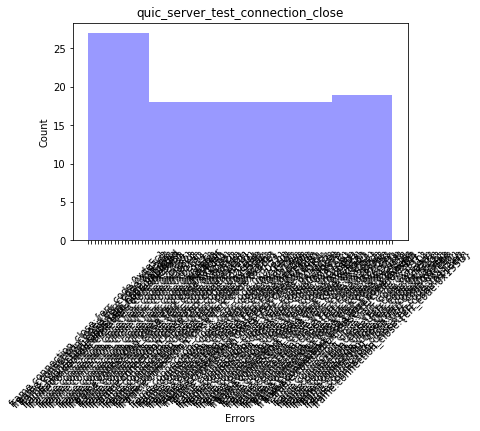

Errors for picoquic in test quic_server_test_connection_close
['No Error' 'frame.connection_close:{err_code:0x6c5d}'
 'frame.connection_close:{err_code:0xde70}'
 'frame.connection_close:{err_code:0x2e06}'
 'frame.connection_close:{err_code:0x5472}'
 'frame.connection_close:{err_code:0x8e17}'
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"'
 'frame.connection_close:{err_code:0x716f}'
 'frame.connection_close:{err_code:0xdbf9}'
 'frame.connection_close:{err_code:0xcb31}' 'Handshake not completed'
 'frame.connection_close:{err_code:0x313a}'
 'frame.connection_close:{err_code:0x7947}'
 'frame.connection_close:{err_code:0x82e0}'
 'frame.connection_close:{err_code:0xacc8}'
 'frame.connection_close:{err_code:0x849f}'
 'frame.connection_close:{err_code:0x6a78}'
 'frame.connection_close:{err_code:0x83c7}'
 'frame.connection_close:{err_code:0x7f54}'
 'frame.connection_close:{err_code:0x51c2}'
 'frame.connection_close:{err_code:0x635b}'
 'frame.connection_close:{err_code:

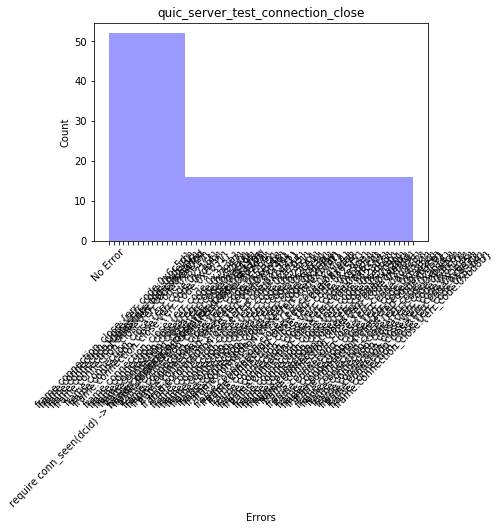

Errors for quic-go in test quic_server_test_connection_close
['frame.connection_close:{err_code:0x1e16}'
 'frame.connection_close:{err_code:0x133f}'
 'frame.connection_close:{err_code:0x266}'
 'frame.connection_close:{err_code:0x5d88}'
 'frame.connection_close:{err_code:0x17aa}'
 'frame.connection_close:{err_code:0x2ec6}'
 'frame.connection_close:{err_code:0x62ab}'
 'frame.connection_close:{err_code:0x6540}'
 'frame.connection_close:{err_code:0x4377}'
 'frame.connection_close:{err_code:0x5d02}'
 'frame.connection_close:{err_code:0x6269}'
 'frame.connection_close:{err_code:0x2d6b}'
 'frame.connection_close:{err_code:0xa9cf}'
 'frame.connection_close:{err_code:0x1871}'
 'frame.connection_close:{err_code:0xb2c3}'
 'frame.connection_close:{err_code:0xae6a}'
 'frame.connection_close:{err_code:0x3997}'
 'frame.connection_close:{err_code:0x816f}'
 'frame.connection_close:{err_code:0xd2d6}'
 'frame.connection_close:{err_code:0xa8e0}'
 'frame.connection_close:{err_code:0x63df}'
 'frame.connecti

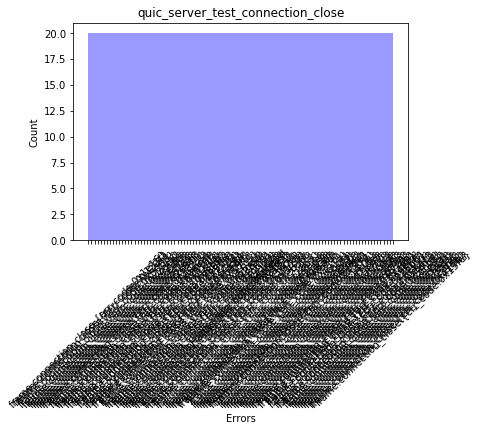

Errors for aioquic in test quic_server_test_connection_close
['frame.connection_close:{err_code:0x413b}'
 'frame.connection_close:{err_code:0xc0a8}'
 'frame.connection_close:{err_code:0x7956}'
 'frame.connection_close:{err_code:0x95ba}'
 'frame.connection_close:{err_code:0x8a68}'
 'frame.connection_close:{err_code:0xe657}' 'No Error'
 'frame.connection_close:{err_code:0xa}'
 'frame.connection_close:{err_code:0x5416}'
 'frame.connection_close:{err_code:0x6a53}'
 'frame.connection_close:{err_code:0x9561}'
 'frame.connection_close:{err_code:0x5ca5}'
 'frame.connection_close:{err_code:0xbbe2}'
 'frame.connection_close:{err_code:0xbf1}'
 'frame.connection_close:{err_code:0x8bbc}'
 'frame.connection_close:{err_code:0x9e62}'
 'frame.connection_close:{err_code:0x2046}'
 'frame.connection_close:{err_code:0x466c}'
 'frame.connection_close:{err_code:0x8675}'
 'frame.connection_close:{err_code:0x7051}'
 'frame.connection_close:{err_code:0x5706}'
 'frame.connection_close:{err_code:0xa028}'
 'frame.

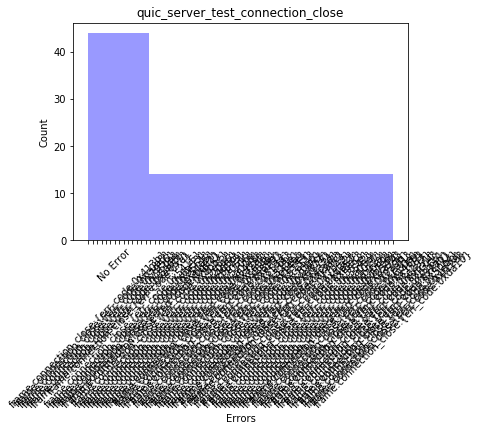

Errors for quinn in test quic_server_test_reset_stream
['require stream_id_allowed(dcid,f.id);  # [6]"'
 'require ~path_challenge_pending(dcid,f.data);"'
 'Handshake not completed']
Run
171    31
172    31
173    31
174    31
495    31
Name: ErrorsCode, dtype: int64
[0 1 2]
('require stream_id_allowed(dcid,f.id);  # [6]"', 'require ~path_challenge_pending(dcid,f.data);"', 'Handshake not completed')


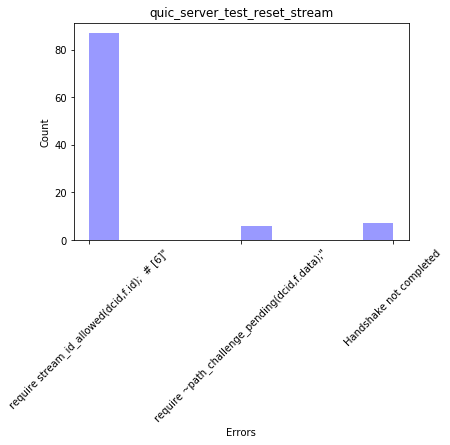

Errors for mvfst in test quic_server_test_reset_stream
['Handshake not completed' 'frame.connection_close:{err_code:0xc}'
 'Segmentation Fault 134' 'No Error']
Run
175    0
176    0
177    0
178    0
497    0
Name: ErrorsCode, dtype: int64
[0 1 2 3]
('Handshake not completed', 'frame.connection_close:{err_code:0xc}', 'Segmentation Fault 134', 'No Error')


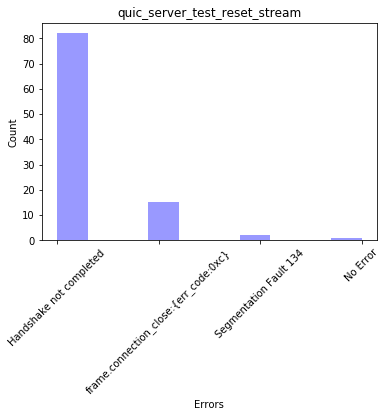

Errors for picoquic in test quic_server_test_reset_stream
['require stream_id_allowed(dcid,f.id);  # [4]"' 'No Error'
 'Handshake not completed'
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']
Run
179    32
180    32
181     2
182     0
499    32
Name: ErrorsCode, dtype: int64
[0 1 2 3]
('require stream_id_allowed(dcid,f.id);  # [4]"', 'No Error', 'Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"')


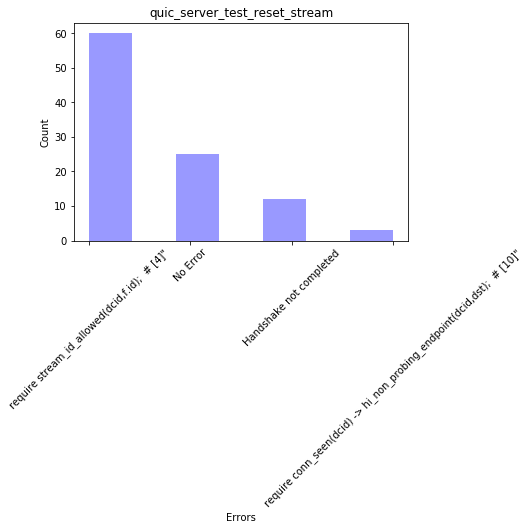

Errors for quic-go in test quic_server_test_reset_stream
['Handshake not completed']
Run
187    0
188    0
189    0
190    0
503    0
Name: ErrorsCode, dtype: int64
[0]
('Handshake not completed',)


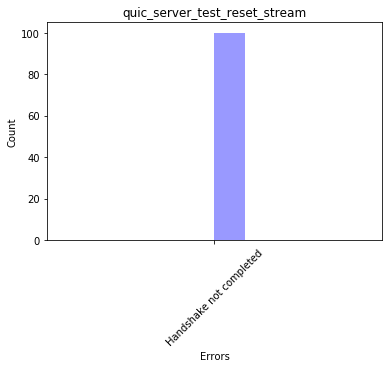

Errors for aioquic in test quic_server_test_reset_stream
['No Error' 'frame.connection_close:{err_code:0xa}'
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"'
 'Handshake not completed']
Run
191    2
192    2
193    2
194    1
505    2
Name: ErrorsCode, dtype: int64
[0 1 2 3]
('No Error', 'frame.connection_close:{err_code:0xa}', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'Handshake not completed')


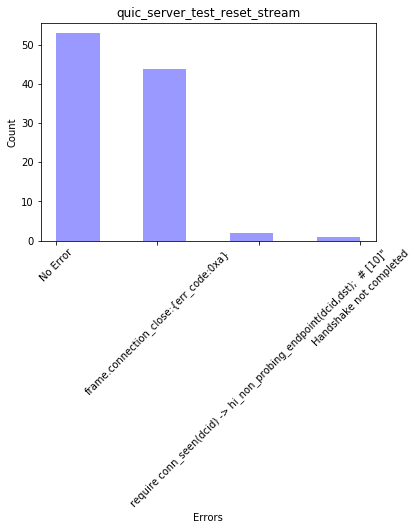

Errors for quinn in test quic_server_test_retirecoid_error
['Run out of cid' 'Handshake not completed'
 'server_return_code(-4)+ivy_return_code(1)']
Run
195    33
196    33
197    33
198    33
507    33
Name: ErrorsCode, dtype: int64
[0 1 2]
('Run out of cid', 'Handshake not completed', 'server_return_code(-4)+ivy_return_code(1)')


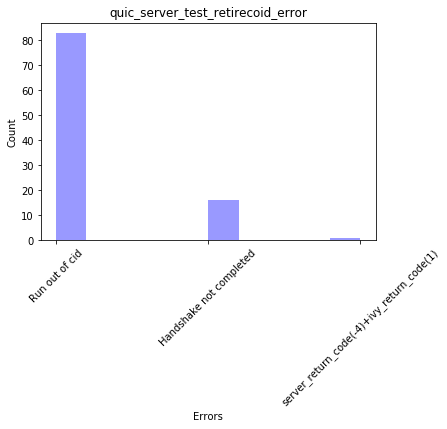

Errors for mvfst in test quic_server_test_retirecoid_error
['Handshake not completed' 'frame.connection_close:{err_code:0xc}'
 'Run out of cid']
Run
199     0
200    34
201     0
202     0
509    34
Name: ErrorsCode, dtype: int64
[0 1 2]
('Handshake not completed', 'frame.connection_close:{err_code:0xc}', 'Run out of cid')


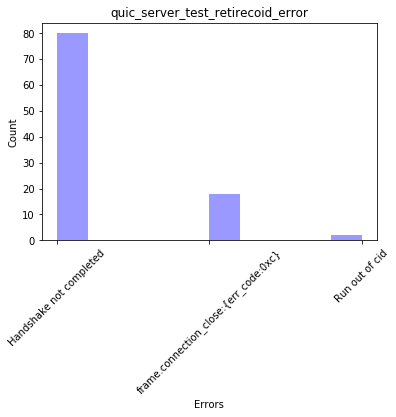

Errors for picoquic in test quic_server_test_retirecoid_error
['Run out of cid' 'Handshake not completed'
 'frame.connection_close:{err_code:0xa}' 'No Error']
Run
203    33
204     0
205    33
206    33
511    33
Name: ErrorsCode, dtype: int64
[0 1 2 3]
('Run out of cid', 'Handshake not completed', 'frame.connection_close:{err_code:0xa}', 'No Error')


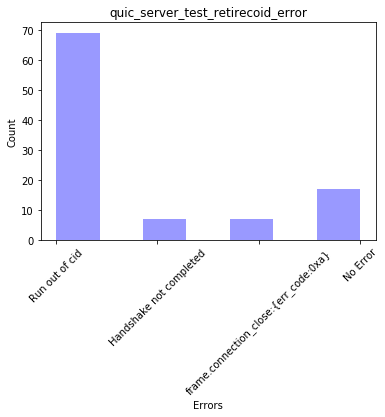

Errors for quic-go in test quic_server_test_retirecoid_error
['Handshake not completed']
Run
211    0
212    0
213    0
515    0
743    0
Name: ErrorsCode, dtype: int64
[0]
('Handshake not completed',)


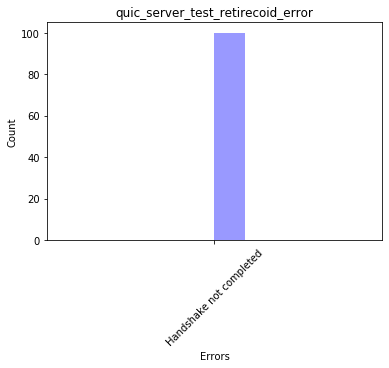

Errors for aioquic in test quic_server_test_retirecoid_error
['Run out of cid' 'Handshake not completed' 'No Error'
 'Segmentation Fault 134']
Run
214    33
215    33
216    33
516     0
517    33
Name: ErrorsCode, dtype: int64
[0 1 2 3]
('Run out of cid', 'Handshake not completed', 'No Error', 'Segmentation Fault 134')


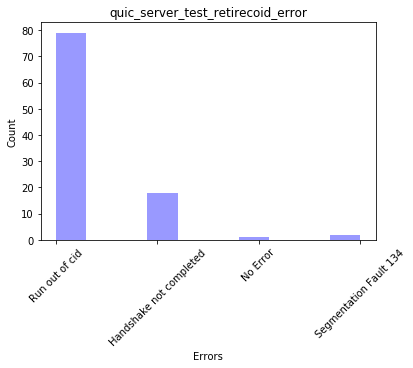

Errors for quinn in test quic_server_test_newcoid_zero_error
['require ~path_challenge_pending(dcid,f.data);"' 'require dcid = 0;"'
 'Handshake not completed']
Run
217    35
218    36
219     0
220     0
518     0
Name: ErrorsCode, dtype: int64
[0 1 2]
('require ~path_challenge_pending(dcid,f.data);"', 'require dcid = 0;"', 'Handshake not completed')


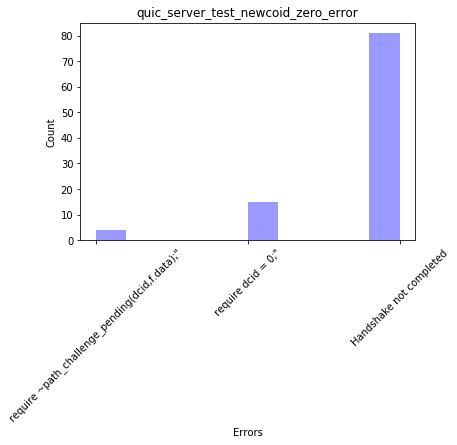

Errors for mvfst in test quic_server_test_newcoid_zero_error
['Handshake not completed' 'frame.connection_close:{err_code:0xc}'
 'require dcid = 0;"' 'Segmentation Fault 134']
Run
221     0
222     0
223    34
224     0
520     0
Name: ErrorsCode, dtype: int64
[0 1 2 3]
('Handshake not completed', 'frame.connection_close:{err_code:0xc}', 'require dcid = 0;"', 'Segmentation Fault 134')


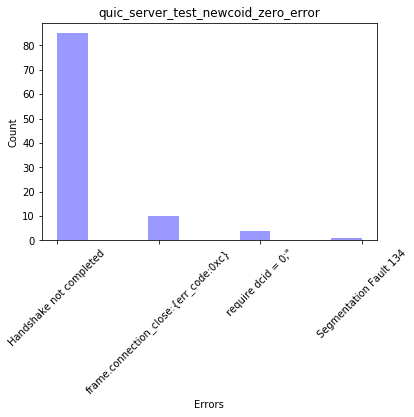

Errors for picoquic in test quic_server_test_newcoid_zero_error
['Handshake not completed'
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"'
 'require dcid = 0;"' 'require is_protocol_violation"']
Run
225    0
226    0
227    8
228    0
522    0
Name: ErrorsCode, dtype: int64
[0 1 2 3]
('Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'require dcid = 0;"', 'require is_protocol_violation"')


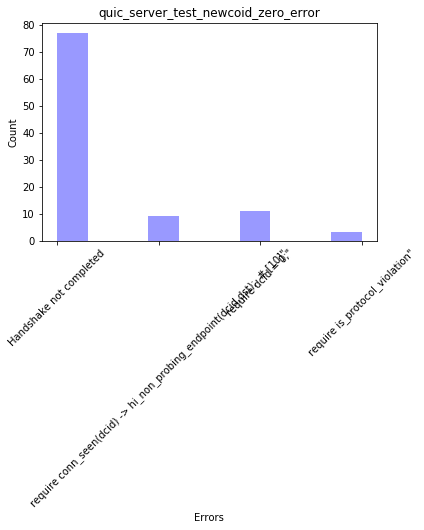

Errors for quic-go in test quic_server_test_newcoid_zero_error
['Handshake not completed']
Run
233    0
234    0
235    0
236    0
526    0
Name: ErrorsCode, dtype: int64
[0]
('Handshake not completed',)


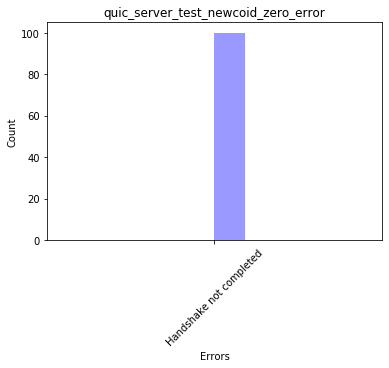

Errors for aioquic in test quic_server_test_newcoid_zero_error
['No Error' 'require dcid = 0;"' 'Handshake not completed'
 'frame.connection_close:{err_code:0xa}'
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']
Run
237     2
238     2
239    36
240     0
528     0
Name: ErrorsCode, dtype: int64
[0 1 2 3 4]
('No Error', 'require dcid = 0;"', 'Handshake not completed', 'frame.connection_close:{err_code:0xa}', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"')


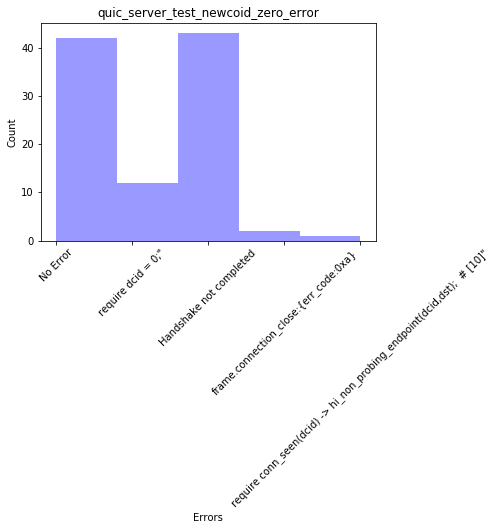

Errors for quinn in test quic_server_test_handshake_done_error
['No Error' 'require is_protocol_violation"' 'Handshake not completed']
Run
241    2
242    2
243    2
244    2
530    2
Name: ErrorsCode, dtype: int64
[0 1 2]
('No Error', 'require is_protocol_violation"', 'Handshake not completed')


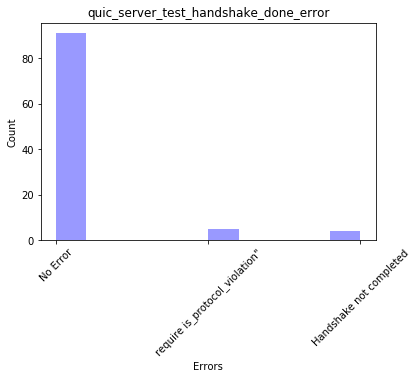

Errors for mvfst in test quic_server_test_handshake_done_error
['Segmentation Fault 139' 'Handshake not completed' 'No Error'
 'require is_protocol_violation"']
Run
245    4
246    0
247    0
248    4
532    4
Name: ErrorsCode, dtype: int64
[0 1 2 3]
('Segmentation Fault 139', 'Handshake not completed', 'No Error', 'require is_protocol_violation"')


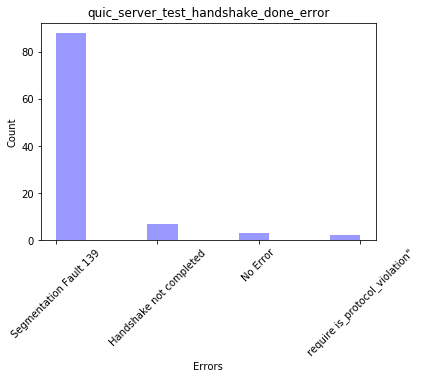

Errors for picoquic in test quic_server_test_handshake_done_error
['No Error' 'Handshake not completed' 'require is_protocol_violation"']
Run
249    2
250    2
251    2
252    2
534    2
Name: ErrorsCode, dtype: int64
[0 1 2]
('No Error', 'Handshake not completed', 'require is_protocol_violation"')


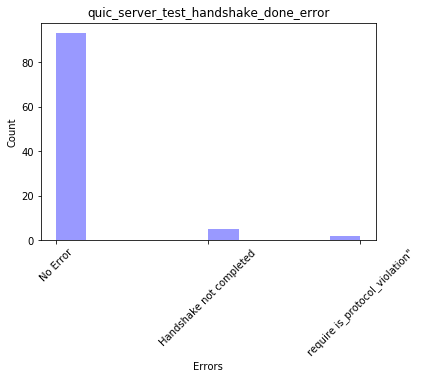

Errors for quic-go in test quic_server_test_handshake_done_error
['frame.connection_close:{err_code:0x7}' 'require is_protocol_violation"'
 'Handshake not completed']
Run
257    5
258    5
259    5
260    5
538    5
Name: ErrorsCode, dtype: int64
[0 1 2]
('frame.connection_close:{err_code:0x7}', 'require is_protocol_violation"', 'Handshake not completed')


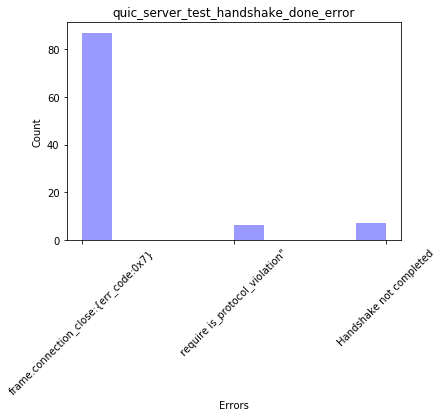

Errors for aioquic in test quic_server_test_handshake_done_error
['Handshake not completed' 'No Error' 'require is_protocol_violation"']
Run
261    0
262    2
263    2
264    2
540    2
Name: ErrorsCode, dtype: int64
[0 1 2]
('Handshake not completed', 'No Error', 'require is_protocol_violation"')


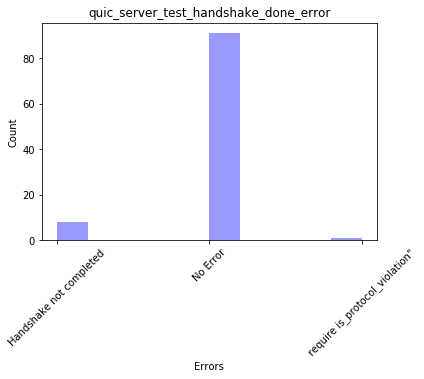

Errors for quinn in test quic_server_test_stop_sending
['require conn_total_data(the_cid) > 0;"'
 'require ~path_challenge_pending(dcid,f.data);"'
 'Handshake not completed']
Run
265    37
266    37
267    37
268    35
542    37
Name: ErrorsCode, dtype: int64
[0 1 2]
('require conn_total_data(the_cid) > 0;"', 'require ~path_challenge_pending(dcid,f.data);"', 'Handshake not completed')


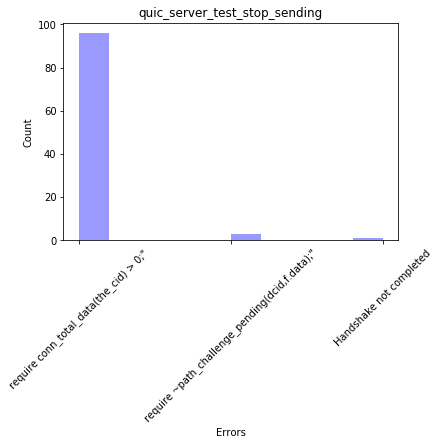

Errors for mvfst in test quic_server_test_stop_sending
['Handshake not completed' 'require conn_total_data(the_cid) > 0;"'
 'frame.connection_close:{err_code:0xc}']
Run
269     0
270     0
271     0
272     0
544    37
Name: ErrorsCode, dtype: int64
[0 1 2]
('Handshake not completed', 'require conn_total_data(the_cid) > 0;"', 'frame.connection_close:{err_code:0xc}')


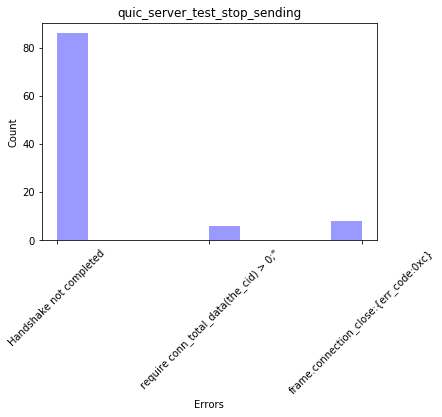

Errors for picoquic in test quic_server_test_stop_sending
['require conn_total_data(the_cid) > 0;"' 'No Error'
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']
Run
273    37
274    37
275    37
276    37
546    37
Name: ErrorsCode, dtype: int64
[0 1 2]
('require conn_total_data(the_cid) > 0;"', 'No Error', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"')


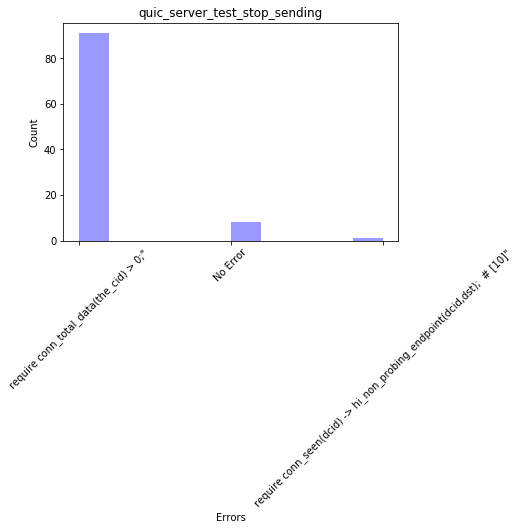

Errors for quic-go in test quic_server_test_stop_sending
['Handshake not completed']
Run
281    0
282    0
283    0
284    0
550    0
Name: ErrorsCode, dtype: int64
[0]
('Handshake not completed',)


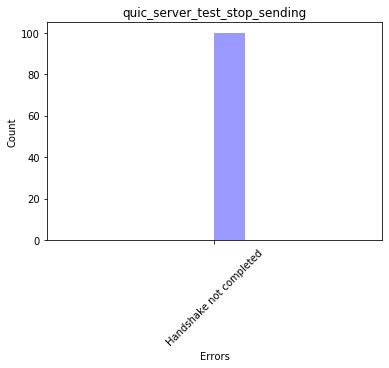

Errors for aioquic in test quic_server_test_stop_sending
['require conn_total_data(the_cid) > 0;"' 'No Error'
 'Handshake not completed']
Run
285    37
286    37
287    37
288    37
552     2
Name: ErrorsCode, dtype: int64
[0 1 2]
('require conn_total_data(the_cid) > 0;"', 'No Error', 'Handshake not completed')


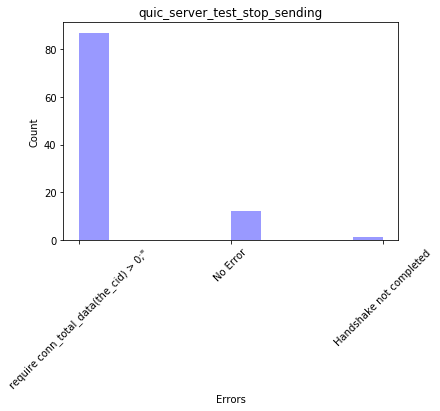

Errors for quinn in test quic_server_test_double_tp_error
['No Error']
Run
289    2
290    2
291    2
292    2
554    2
Name: ErrorsCode, dtype: int64
[0]
('No Error',)


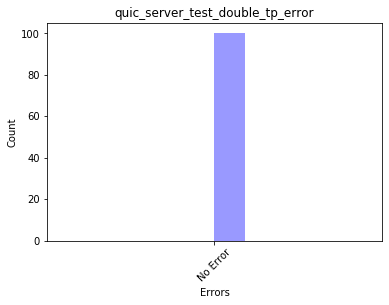

Errors for mvfst in test quic_server_test_double_tp_error
['frame.connection_close:{err_code:0xc}' 'Handshake not completed']
Run
293    34
294     0
295     0
296     0
556     0
Name: ErrorsCode, dtype: int64
[0 1]
('frame.connection_close:{err_code:0xc}', 'Handshake not completed')


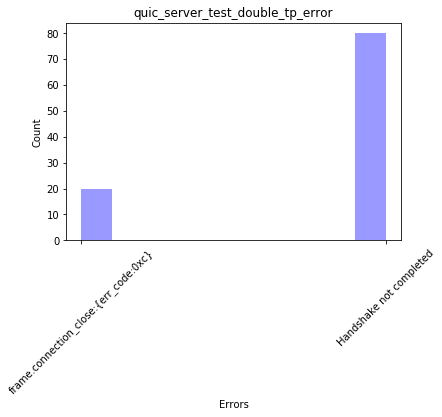

Errors for picoquic in test quic_server_test_double_tp_error
['No Error']
Run
297    2
298    2
299    2
300    2
558    2
Name: ErrorsCode, dtype: int64
[0]
('No Error',)


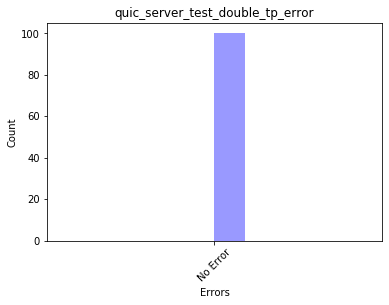

Errors for quic-go in test quic_server_test_double_tp_error
['No Error']
Run
305    2
306    2
307    2
308    2
562    2
Name: ErrorsCode, dtype: int64
[0]
('No Error',)


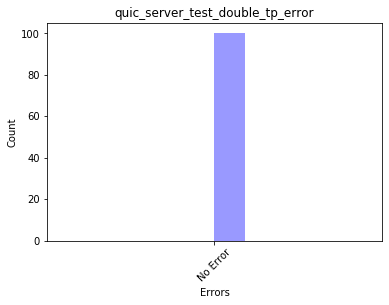

Errors for aioquic in test quic_server_test_double_tp_error
['frame.connection_close:{err_code:0xa}' 'Handshake not completed'
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"'
 'require is_transport_parameter_error;"']
Run
309    1
310    0
311    8
312    0
564    0
Name: ErrorsCode, dtype: int64
[0 1 2 3]
('frame.connection_close:{err_code:0xa}', 'Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'require is_transport_parameter_error;"')


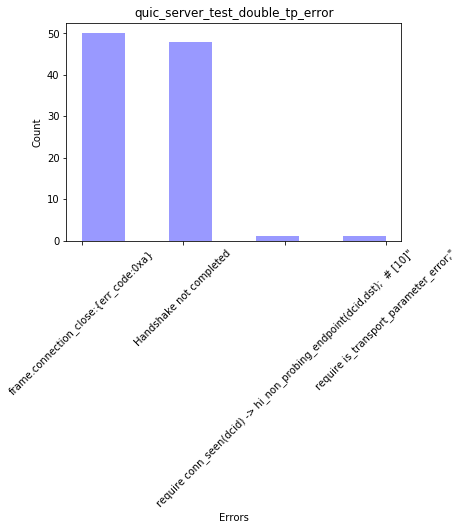

Errors for quinn in test quic_server_test_tp_limit_acticoid_error
['Run out of cid' 'Handshake not completed'
 'require is_connection_id_limit_error;"']
Run
313    33
314    33
565     0
566    33
795    33
Name: ErrorsCode, dtype: int64
[0 1 2]
('Run out of cid', 'Handshake not completed', 'require is_connection_id_limit_error;"')


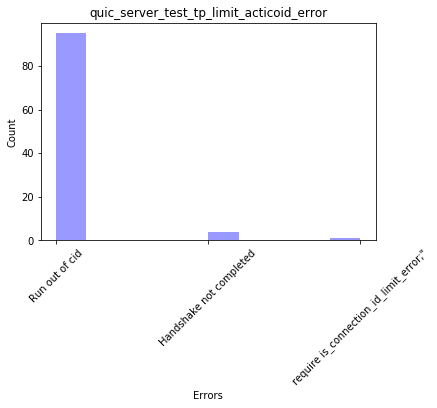

Errors for mvfst in test quic_server_test_tp_limit_acticoid_error
['Run out of cid' 'Handshake not completed'
 'frame.connection_close:{err_code:0xc}'
 'frame.connection_close:{err_code:0xa}']
Run
315    33
316     0
317     0
318    33
567     0
Name: ErrorsCode, dtype: int64
[0 1 2 3]
('Run out of cid', 'Handshake not completed', 'frame.connection_close:{err_code:0xc}', 'frame.connection_close:{err_code:0xa}')


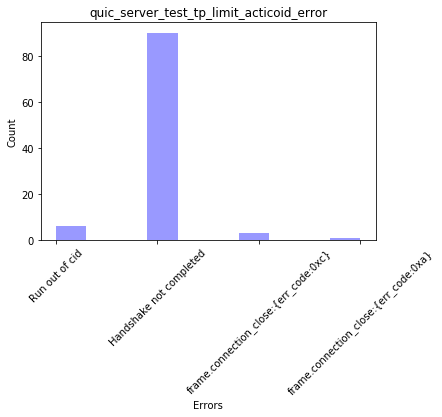

Errors for picoquic in test quic_server_test_tp_limit_acticoid_error
['Run out of cid' 'frame.connection_close:{err_code:0xa}']
Run
319    33
320    33
321    33
322    33
569    33
Name: ErrorsCode, dtype: int64
[0 1]
('Run out of cid', 'frame.connection_close:{err_code:0xa}')


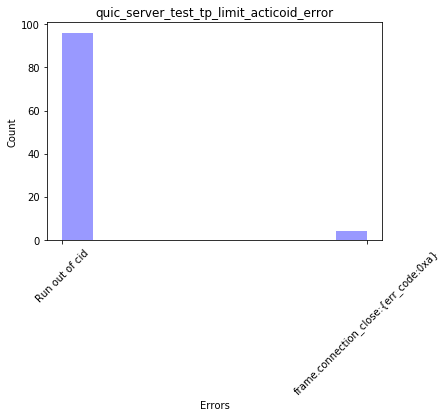

Errors for quic-go in test quic_server_test_tp_limit_acticoid_error
['Handshake not completed']
Run
327    0
328    0
329    0
330    0
573    0
Name: ErrorsCode, dtype: int64
[0]
('Handshake not completed',)


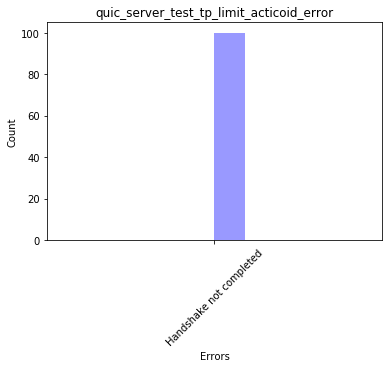

Errors for aioquic in test quic_server_test_tp_limit_acticoid_error
['Run out of cid' 'Segmentation Fault 134' 'Handshake not completed'
 'frame.connection_close:{err_code:0xa}']
Run
331    33
332    33
333    33
334    33
575    33
Name: ErrorsCode, dtype: int64
[0 1 2 3]
('Run out of cid', 'Segmentation Fault 134', 'Handshake not completed', 'frame.connection_close:{err_code:0xa}')


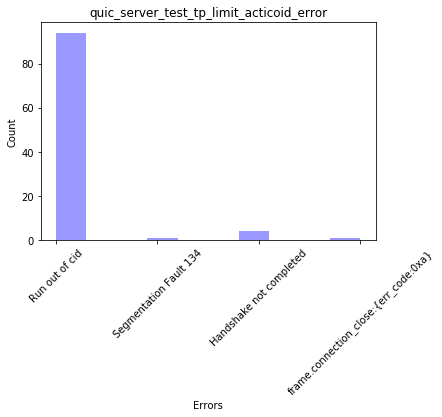

Errors for quinn in test quic_server_test_accept_maxdata
['No Error' 'require ~path_challenge_pending(dcid,f.data);"'
 'Handshake not completed']
Run
335     2
336    35
337    35
338     2
577     2
Name: ErrorsCode, dtype: int64
[0 1 2]
('No Error', 'require ~path_challenge_pending(dcid,f.data);"', 'Handshake not completed')


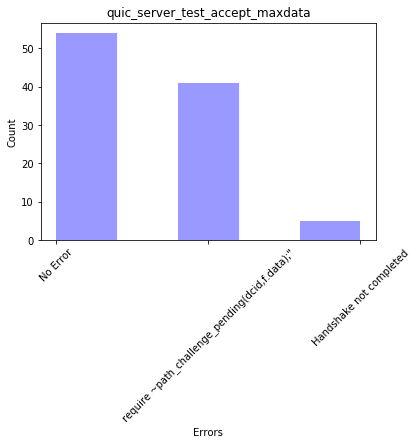

Errors for mvfst in test quic_server_test_accept_maxdata
['No Error']
Run
339    2
340    2
341    2
342    2
579    2
Name: ErrorsCode, dtype: int64
[0]
('No Error',)


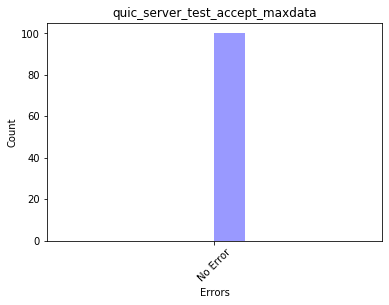

Errors for picoquic in test quic_server_test_accept_maxdata
['require ~is_no_error;"' 'No Error' 'Handshake not completed'
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"'
 'require stream_id_allowed(dcid,f.id);  # [4]"']
Run
343    38
344     2
345     0
346    38
581     0
Name: ErrorsCode, dtype: int64
[0 1 2 3 4]
('require ~is_no_error;"', 'No Error', 'Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'require stream_id_allowed(dcid,f.id);  # [4]"')


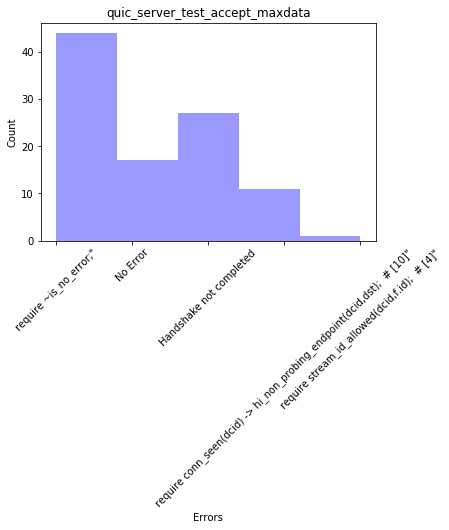

Errors for quic-go in test quic_server_test_accept_maxdata
['No Error' 'Handshake not completed']
Run
351    2
352    2
353    2
354    2
585    2
Name: ErrorsCode, dtype: int64
[0 1]
('No Error', 'Handshake not completed')


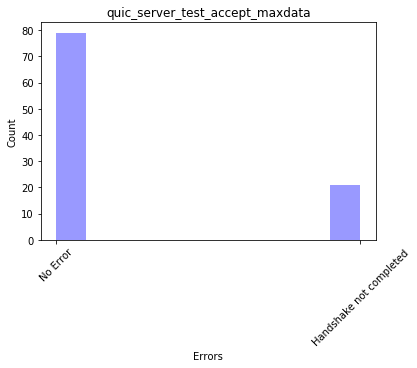

Errors for aioquic in test quic_server_test_accept_maxdata
['No Error'
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']
Run
355    2
356    2
357    2
358    2
587    2
Name: ErrorsCode, dtype: int64
[0 1]
('No Error', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"')


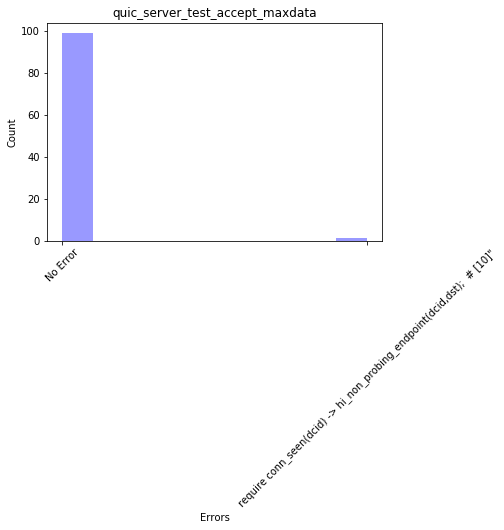

Errors for quinn in test quic_server_test_no_icid
['require initial_source_connection_id.is_set(trans_params(scid));  # [5]"']
Run
359    39
360    39
361    39
362    39
589    39
Name: ErrorsCode, dtype: int64
[0]
('require initial_source_connection_id.is_set(trans_params(scid));  # [5]"',)


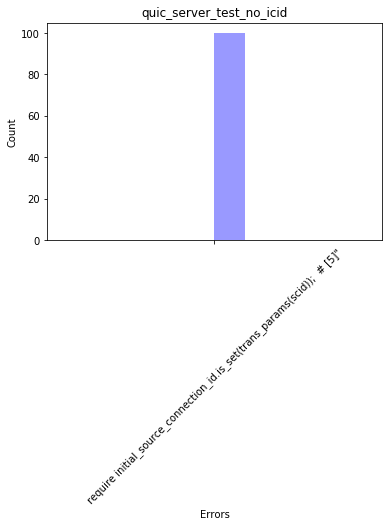

Errors for mvfst in test quic_server_test_no_icid
['require initial_source_connection_id.is_set(trans_params(scid));  # [5]"']
Run
363    39
364    39
365    39
366    39
591    39
Name: ErrorsCode, dtype: int64
[0]
('require initial_source_connection_id.is_set(trans_params(scid));  # [5]"',)


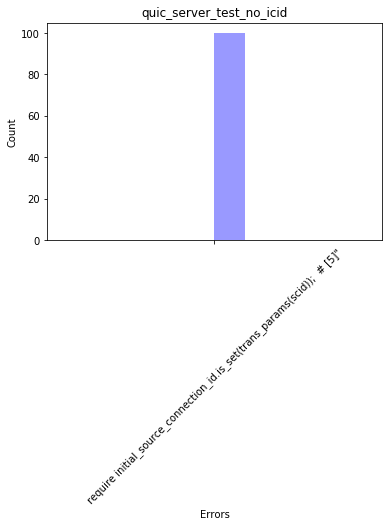

Errors for picoquic in test quic_server_test_no_icid
['require initial_source_connection_id.is_set(trans_params(scid));  # [5]"']
Run
367    39
368    39
369    39
370    39
593    39
Name: ErrorsCode, dtype: int64
[0]
('require initial_source_connection_id.is_set(trans_params(scid));  # [5]"',)


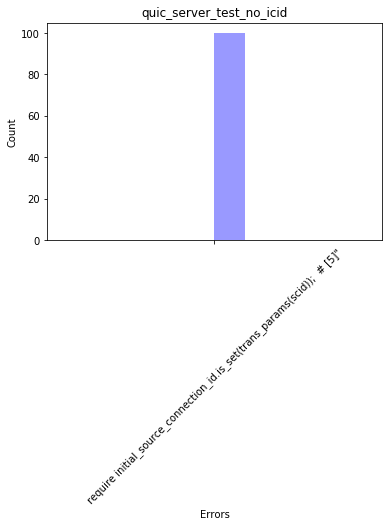

Errors for quic-go in test quic_server_test_no_icid
['require initial_source_connection_id.is_set(trans_params(scid));  # [5]"']
Run
375    39
376    39
377    39
378    39
597    39
Name: ErrorsCode, dtype: int64
[0]
('require initial_source_connection_id.is_set(trans_params(scid));  # [5]"',)


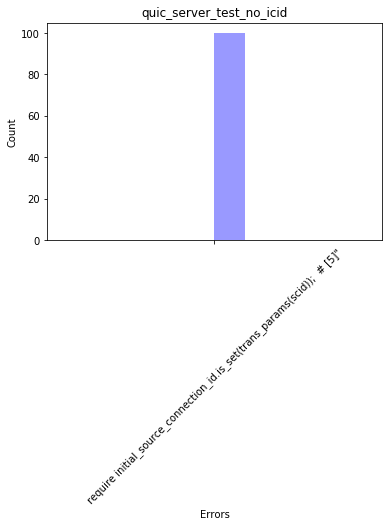

Errors for aioquic in test quic_server_test_no_icid
['require initial_source_connection_id.is_set(trans_params(scid));  # [5]"']
Run
379    39
380    39
381    39
382    39
599    39
Name: ErrorsCode, dtype: int64
[0]
('require initial_source_connection_id.is_set(trans_params(scid));  # [5]"',)


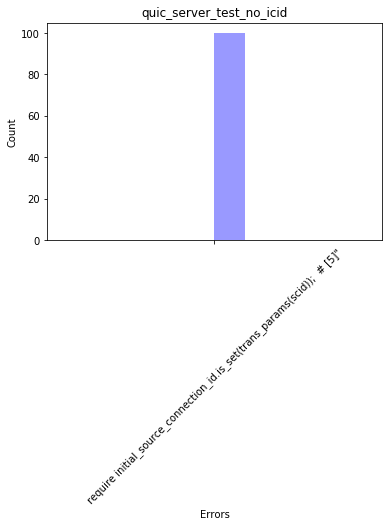

Errors for quinn in test quic_server_test_ext_min_ack_delay
['Handshake not completed'
 'require ~path_challenge_pending(dcid,f.data);"']
Run
383    0
384    0
385    0
386    0
601    0
Name: ErrorsCode, dtype: int64
[0 1]
('Handshake not completed', 'require ~path_challenge_pending(dcid,f.data);"')


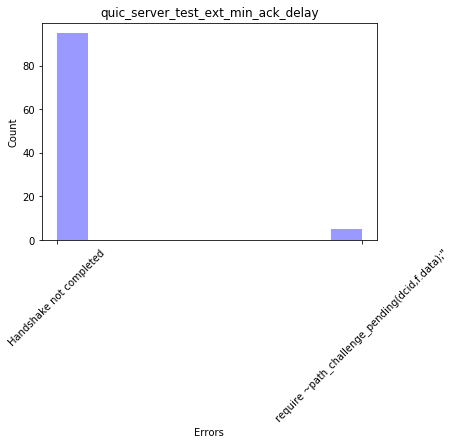

Errors for mvfst in test quic_server_test_ext_min_ack_delay
['Handshake not completed' 'frame.connection_close:{err_code:0xc}'
 'No Error' 'Segmentation Fault 134']
Run
387     0
388     0
389     0
390     0
603    34
Name: ErrorsCode, dtype: int64
[0 1 2 3]
('Handshake not completed', 'frame.connection_close:{err_code:0xc}', 'No Error', 'Segmentation Fault 134')


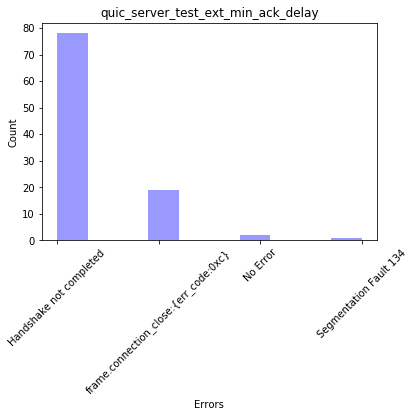

Errors for picoquic in test quic_server_test_ext_min_ack_delay
['No Error'
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"'
 'Handshake not completed'
 'require f.update_max_ack_delay > 0x20; #hardcoded"']
Run
391    2
392    2
393    2
394    8
605    2
Name: ErrorsCode, dtype: int64
[0 1 2 3]
('No Error', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'Handshake not completed', 'require f.update_max_ack_delay > 0x20; #hardcoded"')


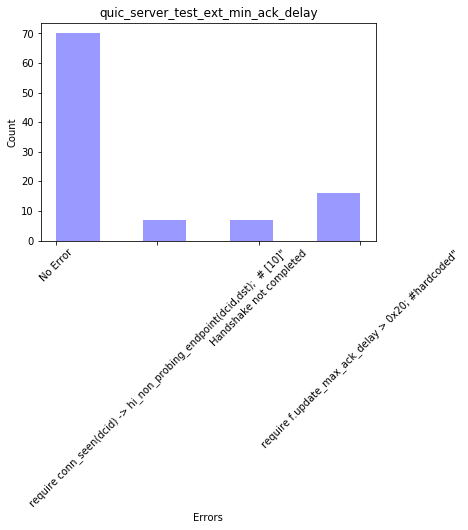

Errors for quic-go in test quic_server_test_ext_min_ack_delay
['Handshake not completed']
Run
399    0
400    0
401    0
402    0
609    0
Name: ErrorsCode, dtype: int64
[0]
('Handshake not completed',)


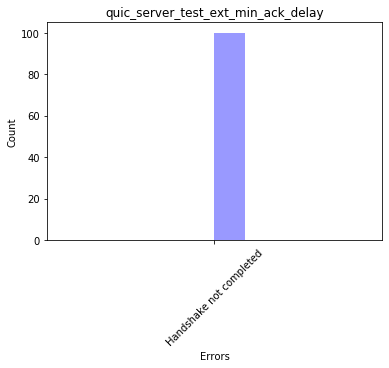

Errors for aioquic in test quic_server_test_ext_min_ack_delay
['frame.connection_close:{err_code:0xa}' 'No Error'
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']
Run
403    1
404    1
405    2
406    2
611    2
Name: ErrorsCode, dtype: int64
[0 1 2]
('frame.connection_close:{err_code:0xa}', 'No Error', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"')


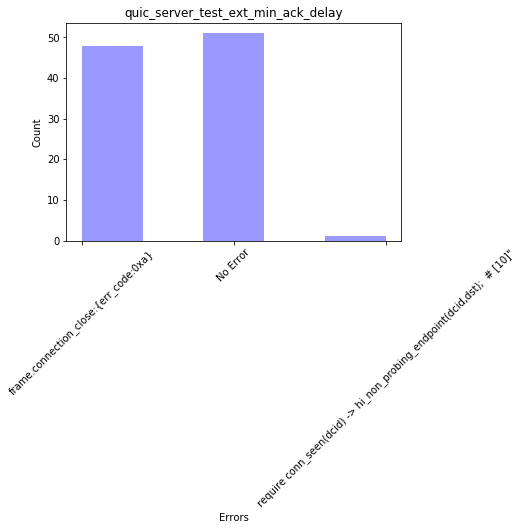

In [115]:
tests = ['quic_server_test_stream', 'quic_server_test_unkown',
       'quic_server_test_tp_limit_newcoid', 'quic_server_test_max',
       'quic_server_test_token_error', 'quic_server_test_tp_error',
       'quic_server_test_tp_acticoid_error',
       'quic_server_test_connection_close',
       'quic_server_test_reset_stream',
       'quic_server_test_retirecoid_error',
       'quic_server_test_newcoid_zero_error',
       'quic_server_test_handshake_done_error',
       'quic_server_test_stop_sending',
       'quic_server_test_double_tp_error',
       'quic_server_test_tp_limit_acticoid_error',
       'quic_server_test_accept_maxdata', 'quic_server_test_no_icid',
       'quic_server_test_ext_min_ack_delay']

# 'quant',
servers = ['quinn', 'mvfst', 'picoquic',  'quic-go', 'aioquic']
#plt.figure(figsize=[10,10])
#f,a = plt.subplots(2,2)
#a = a.ravel()

all_errors = train_df["ErrorIEV"].unique().tolist()
res = []
for i, row in train_df.iterrows():
    ind = all_errors.index(row["ErrorIEV"])
    res.append(ind)
train_df["ErrorsCode"] = res

print(train_df.head(50))

for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    for s in servers:
        subsubdf = subdf.loc[subdf['Implementation'] == s]
        print("Errors for " + s + " in test " + t)
        errors = subsubdf["ErrorIEV"].unique()
        print(errors)
        print(subsubdf['ErrorsCode'].head())
        
        all_errors = subsubdf["ErrorIEV"].unique().tolist()
        res = []
        for i, row in subsubdf.iterrows():
            ind = all_errors.index(row["ErrorIEV"])
            res.append(ind)
        subsubdf["ErrorsCode"] = res
                
        # seaborn histogram
        sns.distplot(subsubdf['ErrorsCode'], hist=True, kde=False, 
                     color='blue')
        # Add labels
        plt.title(t)
        plt.xticks(np.arange(0,len(all_errors)), rotation=45)  #'vertical'
        print(np.arange(0,len(all_errors)))
        positions = tuple(np.arange(0, len(all_errors)))
        labels =  tuple(errors.tolist())
        print(labels)
        plt.xticks(positions, labels)
        plt.xlabel('Errors')
        plt.ylabel('Count')
        plt.show()